ValueError: operands could not be broadcast together with shapes (119,) (2,) 

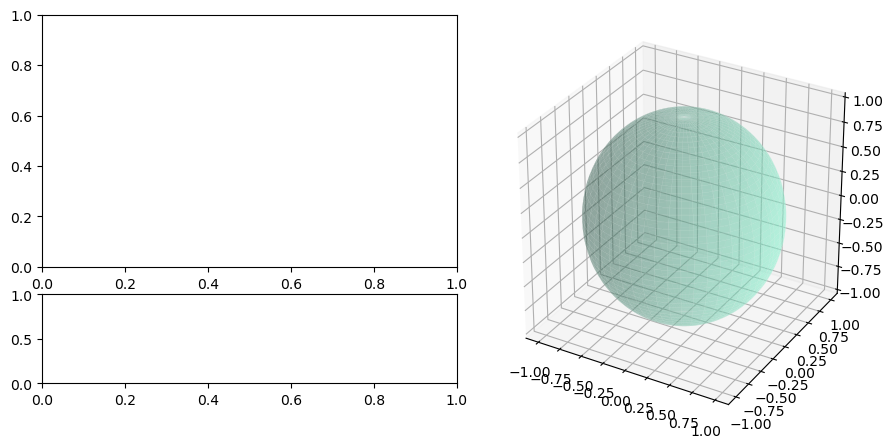

In [1]:
# SGR 0418+5729 fitting
# HS1,2 with stationary emission

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D


# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('SGR 0418+5729_first(blue)_obs.csv', header = 0)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]



# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(35)
# HS1
theta_1_main_ini = np.radians(128)
phi_1_main_ini = np.radians(110)
m_1_main_ini = 3.4
ang_1_sub_ini = np.radians(10)
m_1_sub_ini = 0.8

# HS2
theta_2_main_ini = np.radians(145)
phi_2_main_ini = np.radians(250)
m_2_main_ini = 7
ang_2_sub_ini = np.radians(10)
m_2_sub_ini = 2

# light-bending factor
f_lb = 1. / 3.


#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(2 * math.pi * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(y_rot, np.dot(z_rot, xyz))
    return XYZ_after_rotation

#############################################################################################

def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS1 sub
    x_hs_1_sub_1 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(0))
    y_hs_1_sub_1 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(0))
    z_hs_1_sub_1 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_2 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(90))
    y_hs_1_sub_2 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(90))
    z_hs_1_sub_2 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_3 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(180))
    y_hs_1_sub_3 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(180))
    z_hs_1_sub_3 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_4 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(270))
    y_hs_1_sub_4 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(270))
    z_hs_1_sub_4 = polar_to_rectangular_z(ang_1_sub_ini)

#     hs_1_sub_xyz_1 = np.array([[x_hs_1_sub_1], [y_hs_1_sub_1], [z_hs_1_sub_1]])
#     hs_1_sub_xyz_2 = np.array([[x_hs_1_sub_2], [y_hs_1_sub_2], [z_hs_1_sub_2]])
#     hs_1_sub_xyz_3 = np.array([[x_hs_1_sub_3], [y_hs_1_sub_3], [z_hs_1_sub_3]])
#     hs_1_sub_xyz_4 = np.array([[x_hs_1_sub_4], [y_hs_1_sub_4], [z_hs_1_sub_4]])

#     phi_rot_1 = -phi_1_main_ini
#     theta_rot_1 = -theta_1_main_ini

#     z_rot_1 = np.array([[np.cos(phi_rot_1), np.sin(phi_rot_1), 0], [-np.sin(phi_rot_1), np.cos(phi_rot_1), 0], [0, 0 ,1]])
#     y_rot_1 = np.array([[np.cos(theta_rot_1), 0, -np.sin(theta_rot_1)], [0, 1, 0], [np.sin(theta_rot_1), 0, np.cos(theta_rot_1)]])

#     hs_1_sub_XYZ_1 = np.dot(y_rot_1, np.dot(z_rot_1, hs_1_sub_xyz_1))
#     hs_1_sub_XYZ_2 = np.dot(y_rot_1, np.dot(z_rot_1, hs_1_sub_xyz_2))
#     hs_1_sub_XYZ_3 = np.dot(y_rot_1, np.dot(z_rot_1, hs_1_sub_xyz_3))
#     hs_1_sub_XYZ_4 = np.dot(y_rot_1, np.dot(z_rot_1, hs_1_sub_xyz_4))

    hs_1_sub_XYZ_1 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_1, y_hs_1_sub_1, z_hs_1_sub_1)
    hs_1_sub_XYZ_2 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_2, y_hs_1_sub_2, z_hs_1_sub_2)
    hs_1_sub_XYZ_3 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_3, y_hs_1_sub_3, z_hs_1_sub_3)
    hs_1_sub_XYZ_4 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_4, y_hs_1_sub_4, z_hs_1_sub_4)

    # HS2 sub
    x_hs_2_sub_1 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(0))
    y_hs_2_sub_1 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(0))
    z_hs_2_sub_1 = scale * r * np.cos(ang_2_sub_ini)
    x_hs_2_sub_2 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(90))
    y_hs_2_sub_2 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(90))
    z_hs_2_sub_2 = scale * r * np.cos(ang_2_sub_ini)
    x_hs_2_sub_3 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(180))
    y_hs_2_sub_3 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(180))
    z_hs_2_sub_3 = scale * r * np.cos(ang_2_sub_ini)
    x_hs_2_sub_4 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(270))
    y_hs_2_sub_4 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(270))
    z_hs_2_sub_4 = scale * r * np.cos(ang_2_sub_ini)

    hs_2_sub_xyz_1 = np.array([[x_hs_2_sub_1], [y_hs_2_sub_1], [z_hs_2_sub_1]])
    hs_2_sub_xyz_2 = np.array([[x_hs_2_sub_2], [y_hs_2_sub_2], [z_hs_2_sub_2]])
    hs_2_sub_xyz_3 = np.array([[x_hs_2_sub_3], [y_hs_2_sub_3], [z_hs_2_sub_3]])
    hs_2_sub_xyz_4 = np.array([[x_hs_2_sub_4], [y_hs_2_sub_4], [z_hs_2_sub_4]])

    phi_rot_2 = -phi_2_main_ini
    theta_rot_2 = -theta_2_main_ini

    z_rot_2 = np.array([[np.cos(phi_rot_2), np.sin(phi_rot_2), 0], [-np.sin(phi_rot_2), np.cos(phi_rot_2), 0], [0, 0 ,1]])
    y_rot_2 = np.array([[np.cos(theta_rot_2), 0, -np.sin(theta_rot_2)], [0, 1, 0], [np.sin(theta_rot_2), 0, np.cos(theta_rot_2)]])

    hs_2_sub_XYZ_1 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_1))
    hs_2_sub_XYZ_2 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_2))
    hs_2_sub_XYZ_3 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_3))
    hs_2_sub_XYZ_4 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_4))
    
    theta_1_sub_1 = hs_1_sub_XYZ_1[2, 0]
    phi_1_sub_1 = hs_1_sub_XYZ_1[1, 0], hs_1_sub_XYZ_1[0, 0]
    theta_1_sub_2 = hs_1_sub_XYZ_2[2, 0]
    phi_1_sub_2 = hs_1_sub_XYZ_2[1, 0], hs_1_sub_XYZ_2[0, 0]
    theta_1_sub_3 = hs_1_sub_XYZ_3[2, 0]
    phi_1_sub_3 = hs_1_sub_XYZ_3[1, 0], hs_1_sub_XYZ_3[0, 0]
    theta_1_sub_4 = hs_1_sub_XYZ_4[2, 0]
    phi_1_sub_4 = hs_1_sub_XYZ_4[1, 0], hs_1_sub_XYZ_4[0, 0]

    theta_2_sub_1 = np.arccos(hs_2_sub_XYZ_1[2, 0] / (r * scale))
    phi_2_sub_1 = np.arctan(hs_2_sub_XYZ_1[1, 0] / hs_2_sub_XYZ_1[0, 0])
    theta_2_sub_2 = np.arccos(hs_2_sub_XYZ_2[2, 0] / (r * scale))
    phi_2_sub_2 = np.arctan(hs_2_sub_XYZ_2[1, 0] / hs_2_sub_XYZ_2[0, 0])
    theta_2_sub_3 = np.arccos(hs_2_sub_XYZ_3[2, 0] / (r * scale))
    phi_2_sub_3 = np.arctan(hs_2_sub_XYZ_3[1, 0] / hs_2_sub_XYZ_3[0, 0])
    theta_2_sub_4 = np.arccos(hs_2_sub_XYZ_4[2, 0] / (r * scale))
    phi_2_sub_4 = np.arctan(hs_2_sub_XYZ_4[1, 0] / hs_2_sub_XYZ_4[0, 0])
    
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_1_sub_1, phi_1_sub_1, m_1_sub_ini) + \
            mu(x, i, theta_1_sub_2, phi_1_sub_2, m_1_sub_ini) + \
            mu(x, i, theta_1_sub_3, phi_1_sub_3, m_1_sub_ini) + \
            mu(x, i, theta_1_sub_4, phi_1_sub_4, m_1_sub_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini) + \
            mu(x, i, theta_2_sub_1, phi_2_sub_1, m_2_sub_ini) + \
            mu(x, i, theta_2_sub_2, phi_2_sub_2, m_2_sub_ini) + \
            mu(x, i, theta_2_sub_3, phi_2_sub_3, m_2_sub_ini) + \
            mu(x, i, theta_2_sub_4, phi_2_sub_4, m_2_sub_ini)
    
    return Total

def mu_HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    x_hs_1_sub_1 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(0))
    y_hs_1_sub_1 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(0))
    z_hs_1_sub_1 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_2 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(90))
    y_hs_1_sub_2 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(90))
    z_hs_1_sub_2 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_3 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(180))
    y_hs_1_sub_3 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(180))
    z_hs_1_sub_3 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_4 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(270))
    y_hs_1_sub_4 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(270))
    z_hs_1_sub_4 = polar_to_rectangular_z(ang_1_sub_ini)

    hs_1_sub_XYZ_1 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_1, y_hs_1_sub_1, z_hs_1_sub_1)
    hs_1_sub_XYZ_2 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_2, y_hs_1_sub_2, z_hs_1_sub_2)
    hs_1_sub_XYZ_3 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_3, y_hs_1_sub_3, z_hs_1_sub_3)
    hs_1_sub_XYZ_4 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_4, y_hs_1_sub_4, z_hs_1_sub_4)

    theta_1_sub_1 = rectangular_to_polar_theta(hs_1_sub_XYZ_1[2, 0])
    phi_1_sub_1 = rectangular_to_polar_phi(hs_1_sub_XYZ_1[1, 0], hs_1_sub_XYZ_1[0, 0])
    theta_1_sub_2 = rectangular_to_polar_theta(hs_1_sub_XYZ_2[2, 0])
    phi_1_sub_2 = rectangular_to_polar_phi(hs_1_sub_XYZ_2[1, 0], hs_1_sub_XYZ_2[0, 0])
    theta_1_sub_3 = rectangular_to_polar_theta(hs_1_sub_XYZ_3[2, 0])
    phi_1_sub_3 = rectangular_to_polar_phi(hs_1_sub_XYZ_3[1, 0], hs_1_sub_XYZ_3[0, 0])
    theta_1_sub_4 = rectangular_to_polar_theta(hs_1_sub_XYZ_4[2, 0])
    phi_1_sub_4 = rectangular_to_polar_phi(hs_1_sub_XYZ_4[1, 0], hs_1_sub_XYZ_4[0, 0])
    
    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
          mu(x, i, theta_1_sub_1, phi_1_sub_1, m_1_sub_ini) + \
          mu(x, i, theta_1_sub_2, phi_1_sub_2, m_1_sub_ini) + \
          mu(x, i, theta_1_sub_3, phi_1_sub_3, m_1_sub_ini) + \
          mu(x, i, theta_1_sub_4, phi_1_sub_4, m_1_sub_ini)
    return HS1

def mu_HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    x_hs_2_sub_1 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(0))
    y_hs_2_sub_1 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(0))
    z_hs_2_sub_1 = scale * r * np.cos(ang_2_sub_ini)
    x_hs_2_sub_2 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(90))
    y_hs_2_sub_2 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(90))
    z_hs_2_sub_2 = scale * r * np.cos(ang_2_sub_ini)
    x_hs_2_sub_3 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(180))
    y_hs_2_sub_3 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(180))
    z_hs_2_sub_3 = scale * r * np.cos(ang_2_sub_ini)
    x_hs_2_sub_4 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(270))
    y_hs_2_sub_4 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(270))
    z_hs_2_sub_4 = scale * r * np.cos(ang_2_sub_ini)

    hs_2_sub_xyz_1 = np.array([[x_hs_2_sub_1], [y_hs_2_sub_1], [z_hs_2_sub_1]])
    hs_2_sub_xyz_2 = np.array([[x_hs_2_sub_2], [y_hs_2_sub_2], [z_hs_2_sub_2]])
    hs_2_sub_xyz_3 = np.array([[x_hs_2_sub_3], [y_hs_2_sub_3], [z_hs_2_sub_3]])
    hs_2_sub_xyz_4 = np.array([[x_hs_2_sub_4], [y_hs_2_sub_4], [z_hs_2_sub_4]])

    phi_rot_2 = -phi_2_main_ini
    theta_rot_2 = -theta_2_main_ini

    z_rot_2 = np.array([[np.cos(phi_rot_2), np.sin(phi_rot_2), 0], [-np.sin(phi_rot_2), np.cos(phi_rot_2), 0], [0, 0 ,1]])
    y_rot_2 = np.array([[np.cos(theta_rot_2), 0, -np.sin(theta_rot_2)], [0, 1, 0], [np.sin(theta_rot_2), 0, np.cos(theta_rot_2)]])

    hs_2_sub_XYZ_1 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_1))
    hs_2_sub_XYZ_2 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_2))
    hs_2_sub_XYZ_3 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_3))
    hs_2_sub_XYZ_4 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_4))

    theta_2_sub_1 = np.arccos(hs_2_sub_XYZ_1[2, 0] / (r * scale))
    phi_2_sub_1 = np.arctan(hs_2_sub_XYZ_1[1, 0] / hs_2_sub_XYZ_1[0, 0])
    theta_2_sub_2 = np.arccos(hs_2_sub_XYZ_2[2, 0] / (r * scale))
    phi_2_sub_2 = np.arctan(hs_2_sub_XYZ_2[1, 0] / hs_2_sub_XYZ_2[0, 0])
    theta_2_sub_3 = np.arccos(hs_2_sub_XYZ_3[2, 0] / (r * scale))
    phi_2_sub_3 = np.arctan(hs_2_sub_XYZ_3[1, 0] / hs_2_sub_XYZ_3[0, 0])
    theta_2_sub_4 = np.arccos(hs_2_sub_XYZ_4[2, 0] / (r * scale))
    phi_2_sub_4 = np.arctan(hs_2_sub_XYZ_4[1, 0] / hs_2_sub_XYZ_4[0, 0])
    
    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini) + \
          mu(x, i, theta_2_sub_1, phi_2_sub_1, m_2_sub_ini) + \
          mu(x, i, theta_2_sub_2, phi_2_sub_2, m_2_sub_ini) + \
          mu(x, i, theta_2_sub_3, phi_2_sub_3, m_2_sub_ini) + \
          mu(x, i, theta_2_sub_4, phi_2_sub_4, m_2_sub_ini)
    return HS2

x = np.linspace(0, 2, 5000)












#####################################################
#####################################################



# HS1 sub
x_hs_1_sub_1 = scale * r * np.sin(ang_1_sub_ini) * np.cos(np.radians(0))
y_hs_1_sub_1 = scale * r * np.sin(ang_1_sub_ini) * np.sin(np.radians(0))
z_hs_1_sub_1 = scale * r * np.cos(ang_1_sub_ini)
x_hs_1_sub_2 = scale * r * np.sin(ang_1_sub_ini) * np.cos(np.radians(90))
y_hs_1_sub_2 = scale * r * np.sin(ang_1_sub_ini) * np.sin(np.radians(90))
z_hs_1_sub_2 = scale * r * np.cos(ang_1_sub_ini)
x_hs_1_sub_3 = scale * r * np.sin(ang_1_sub_ini) * np.cos(np.radians(180))
y_hs_1_sub_3 = scale * r * np.sin(ang_1_sub_ini) * np.sin(np.radians(180))
z_hs_1_sub_3 = scale * r * np.cos(ang_1_sub_ini)
x_hs_1_sub_4 = scale * r * np.sin(ang_1_sub_ini) * np.cos(np.radians(270))
y_hs_1_sub_4 = scale * r * np.sin(ang_1_sub_ini) * np.sin(np.radians(270))
z_hs_1_sub_4 = scale * r * np.cos(ang_1_sub_ini)

hs_1_sub_xyz_1 = np.array([[x_hs_1_sub_1], [y_hs_1_sub_1], [z_hs_1_sub_1]])
hs_1_sub_xyz_2 = np.array([[x_hs_1_sub_2], [y_hs_1_sub_2], [z_hs_1_sub_2]])
hs_1_sub_xyz_3 = np.array([[x_hs_1_sub_3], [y_hs_1_sub_3], [z_hs_1_sub_3]])
hs_1_sub_xyz_4 = np.array([[x_hs_1_sub_4], [y_hs_1_sub_4], [z_hs_1_sub_4]])

phi_rot_1 = -phi_1_main_ini
theta_rot_1 = -theta_1_main_ini

z_rot_1 = np.array([[np.cos(phi_rot_1), np.sin(phi_rot_1), 0], [-np.sin(phi_rot_1), np.cos(phi_rot_1), 0], [0, 0 ,1]])
y_rot_1 = np.array([[np.cos(theta_rot_1), 0, -np.sin(theta_rot_1)], [0, 1, 0], [np.sin(theta_rot_1), 0, np.cos(theta_rot_1)]])

hs_1_sub_XYZ_1 = np.dot(y_rot_1, np.dot(z_rot_1, hs_1_sub_xyz_1))
hs_1_sub_XYZ_2 = np.dot(y_rot_1, np.dot(z_rot_1, hs_1_sub_xyz_2))
hs_1_sub_XYZ_3 = np.dot(y_rot_1, np.dot(z_rot_1, hs_1_sub_xyz_3))
hs_1_sub_XYZ_4 = np.dot(y_rot_1, np.dot(z_rot_1, hs_1_sub_xyz_4))

# HS2 sub
x_hs_2_sub_1 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(0))
y_hs_2_sub_1 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(0))
z_hs_2_sub_1 = scale * r * np.cos(ang_2_sub_ini)
x_hs_2_sub_2 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(90))
y_hs_2_sub_2 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(90))
z_hs_2_sub_2 = scale * r * np.cos(ang_2_sub_ini)
x_hs_2_sub_3 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(180))
y_hs_2_sub_3 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(180))
z_hs_2_sub_3 = scale * r * np.cos(ang_2_sub_ini)
x_hs_2_sub_4 = scale * r * np.sin(ang_2_sub_ini) * np.cos(np.radians(270))
y_hs_2_sub_4 = scale * r * np.sin(ang_2_sub_ini) * np.sin(np.radians(270))
z_hs_2_sub_4 = scale * r * np.cos(ang_2_sub_ini)

hs_2_sub_xyz_1 = np.array([[x_hs_2_sub_1], [y_hs_2_sub_1], [z_hs_2_sub_1]])
hs_2_sub_xyz_2 = np.array([[x_hs_2_sub_2], [y_hs_2_sub_2], [z_hs_2_sub_2]])
hs_2_sub_xyz_3 = np.array([[x_hs_2_sub_3], [y_hs_2_sub_3], [z_hs_2_sub_3]])
hs_2_sub_xyz_4 = np.array([[x_hs_2_sub_4], [y_hs_2_sub_4], [z_hs_2_sub_4]])

phi_rot_2 = -phi_2_main_ini
theta_rot_2 = -theta_2_main_ini

z_rot_2 = np.array([[np.cos(phi_rot_2), np.sin(phi_rot_2), 0], [-np.sin(phi_rot_2), np.cos(phi_rot_2), 0], [0, 0 ,1]])
y_rot_2 = np.array([[np.cos(theta_rot_2), 0, -np.sin(theta_rot_2)], [0, 1, 0], [np.sin(theta_rot_2), 0, np.cos(theta_rot_2)]])

hs_2_sub_XYZ_1 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_1))
hs_2_sub_XYZ_2 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_2))
hs_2_sub_XYZ_3 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_3))
hs_2_sub_XYZ_4 = np.dot(y_rot_2, np.dot(z_rot_2, hs_2_sub_xyz_4))

theta_1_sub_1 = np.arccos(hs_1_sub_XYZ_1[2, 0] / (r * scale))
phi_1_sub_1 = np.arctan(hs_1_sub_XYZ_1[1, 0] / hs_1_sub_XYZ_1[0, 0])
theta_1_sub_2 = np.arccos(hs_1_sub_XYZ_2[2, 0] / (r * scale))
phi_1_sub_2 = np.arctan(hs_1_sub_XYZ_2[1, 0] / hs_1_sub_XYZ_2[0, 0])
theta_1_sub_3 = np.arccos(hs_1_sub_XYZ_3[2, 0] / (r * scale))
phi_1_sub_3 = np.arctan(hs_1_sub_XYZ_3[1, 0] / hs_1_sub_XYZ_3[0, 0])
theta_1_sub_4 = np.arccos(hs_1_sub_XYZ_4[2, 0] / (r * scale))
phi_1_sub_4 = np.arctan(hs_1_sub_XYZ_4[1, 0] / hs_1_sub_XYZ_4[0, 0])

theta_2_sub_1 = np.arccos(hs_2_sub_XYZ_1[2, 0] / (r * scale))
phi_2_sub_1 = np.arctan(hs_2_sub_XYZ_1[1, 0] / hs_2_sub_XYZ_1[0, 0])
theta_2_sub_2 = np.arccos(hs_2_sub_XYZ_2[2, 0] / (r * scale))
phi_2_sub_2 = np.arctan(hs_2_sub_XYZ_2[1, 0] / hs_2_sub_XYZ_2[0, 0])
theta_2_sub_3 = np.arccos(hs_2_sub_XYZ_3[2, 0] / (r * scale))
phi_2_sub_3 = np.arctan(hs_2_sub_XYZ_3[1, 0] / hs_2_sub_XYZ_3[0, 0])
theta_2_sub_4 = np.arccos(hs_2_sub_XYZ_4[2, 0] / (r * scale))
phi_2_sub_4 = np.arctan(hs_2_sub_XYZ_4[1, 0] / hs_2_sub_XYZ_4[0, 0])




















# fitting
# parameter_initial = np.array([-1.5, 1, 0.2, 4000])
# parameter_initial_2 = np.array([-1.5, 1, 0.2, 4000])
parameter_initial_3 = np.array([i_ini, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini])

# parameter_initial_4 = np.array([-1.5, 1, 0.2, 4000])

# parameter_optimal, covariance = scipy.optimize.curve_fit(func_3, x_data, y_data, p0 = parameter_initial_3)


# parameter_optimal, covariance = scipy.optimize.curve_fit(mu_total, x_data, y_data, p0 = parameter_initial_3, \
#                                                         bounds = ((0, 0, 0, 0, 7, 0, 0, 0, 0, 7, 0), \
#                                                                   (90, 360, 180, 100, 20.5, 10, 90, 360, 100, 20.5, 10)))

parameter_optimal, covariance = scipy.optimize.curve_fit(mu_total, x_data, y_data, p0 = parameter_initial_3)

print(parameter_optimal)

# y_fitting = func_3(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9])
# y_fitting_same_size_as_y_data = func_3(x_data, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9])
y_fitting = mu_total(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])
y_fitting_same_size_as_y_data = mu_total(x_data, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])



# trajectory of HS
x_track_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.cos(theta_sphere)
y_track_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.sin(theta_sphere)
z_track_hs_1 = scale * r * np.cos(parameter_optimal[1])
x_track_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.cos(theta_sphere)
y_track_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.sin(theta_sphere)
z_track_hs_2 = scale * r * np.cos(parameter_optimal[6])
ax2.scatter(x_track_hs_1, y_track_hs_1, z_track_hs_1, s = 3, color = "silver")
ax2.scatter(x_track_hs_2, y_track_hs_2, z_track_hs_2, s = 3, color = "silver")

# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.cos(parameter_optimal[2])
x_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.cos(parameter_optimal[7])
y_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.sin(parameter_optimal[2])
y_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.sin(parameter_optimal[7])
z_hs_1 = scale * r * np.cos(parameter_optimal[1])
z_hs_2 = scale * r * np.cos(parameter_optimal[6])

x_hs = [x_hs_1, x_hs_2]
y_hs = [y_hs_1, y_hs_2]
z_hs = [z_hs_1, z_hs_2]

HS_main_plot_size = 30
HS_sub_plot_size_1 = m_1_sub_ini / m_1_main_ini * HS_main_plot_size
HS_sub_plot_size_2 = m_2_sub_ini / m_2_main_ini * HS_main_plot_size

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "blue")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "orange")

# positions of HS_sub
ax2.scatter(hs_1_sub_XYZ_1[0, 0], hs_1_sub_XYZ_1[1, 0], hs_1_sub_XYZ_1[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_1_sub_XYZ_2[0, 0], hs_1_sub_XYZ_2[1, 0], hs_1_sub_XYZ_2[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_1_sub_XYZ_3[0, 0], hs_1_sub_XYZ_3[1, 0], hs_1_sub_XYZ_3[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_1_sub_XYZ_4[0, 0], hs_1_sub_XYZ_4[1, 0], hs_1_sub_XYZ_4[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_2_sub_XYZ_1[0, 0], hs_2_sub_XYZ_1[1, 0], hs_2_sub_XYZ_1[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "lime")
ax2.scatter(hs_2_sub_XYZ_2[0, 0], hs_2_sub_XYZ_2[1, 0], hs_2_sub_XYZ_2[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "lime")
ax2.scatter(hs_2_sub_XYZ_3[0, 0], hs_2_sub_XYZ_3[1, 0], hs_2_sub_XYZ_3[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "lime")
ax2.scatter(hs_2_sub_XYZ_4[0, 0], hs_2_sub_XYZ_4[1, 0], hs_2_sub_XYZ_4[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "lime")



HS1 = mu_HS1(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5])
HS2 = mu_HS2(x, parameter_optimal[0], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])



# data of pulse profile
ax1.scatter(x_data, y_data, s = 5, c = "dimgrey")
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", color = "blue")
ax1.plot(x, HS2, label = "HS2", color = "orange")
ax1.plot(x, y_fitting, label = 'total', color = 'lime')
# info
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("SGR 0418+5729, 0.5-10 keV, light-bending model with stationary emission")
# ax.text(1.8, 0.325, r"$\theta = \frac{\pi}{5}$")
# ax.text(1.8, 0.31, r"$i = \frac{\pi}{3}$")
# ax.text(1.8, 0.295, r"$\phi = \pi$")
# ax.text(0.8, 0.32, r"$amp = 0.345$")
# plt.title("3XMM J185246.6+003317のパルス波形と手合わせ曲線", fontname = "MS Gothic")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = np.degrees(parameter_optimal[0]), azim = 0)
ax2.axis("off")

# ax3.plot(x_data, y_data - func(x_data, a_p_1, b, c_p_1, d_p_1) - func(x_data, a_p_2, b, c_p_2, d_p_2) - func(x_data, a_p_3, b, c_p_3, d_p_3))
ax3.plot(x_data, (y_data - y_fitting_same_size_as_y_data) / y_data)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("inclination angle:", np.degrees(parameter_optimal[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal[1]), np.degrees(parameter_optimal[2]), parameter_optimal[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal[4]), parameter_optimal[5])
print("Hot_spot_2:", np.degrees(parameter_optimal[6]), np.degrees(parameter_optimal[7]), parameter_optimal[8])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal[9]), parameter_optimal[10])

In [2]:
# SGR 0418+5729 fitting
# HS1,2 with stationary emission

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D


# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('SGR 0418+5729_first(blue)_obs.csv', header = 0)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]



# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(35)
# HS1
theta_1_main_ini = np.radians(128)
phi_1_main_ini = np.radians(110)
m_1_main_ini = 3.4
ang_1_sub_ini = np.radians(10)
m_1_sub_ini = 0.8

# HS2
theta_2_main_ini = np.radians(145)
phi_2_main_ini = np.radians(250)
m_2_main_ini = 7
ang_2_sub_ini = np.radians(10)
m_2_sub_ini = 2

# light-bending factor
f_lb = 1. / 3.


# sub_hot_spot_number
N_sub = 10

#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(2 * math.pi * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(z_rot, np.dot(y_rot, xyz))
    return XYZ_after_rotation

def sub_hot_spot():

#############################################################################################

def HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    x_hs_1_sub_1 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(0))
    y_hs_1_sub_1 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(0))
    z_hs_1_sub_1 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_2 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(90))
    y_hs_1_sub_2 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(90))
    z_hs_1_sub_2 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_3 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(180))
    y_hs_1_sub_3 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(180))
    z_hs_1_sub_3 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_4 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(270))
    y_hs_1_sub_4 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(270))
    z_hs_1_sub_4 = polar_to_rectangular_z(ang_1_sub_ini)

    hs_1_sub_XYZ_1 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_1, y_hs_1_sub_1, z_hs_1_sub_1)
    hs_1_sub_XYZ_2 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_2, y_hs_1_sub_2, z_hs_1_sub_2)
    hs_1_sub_XYZ_3 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_3, y_hs_1_sub_3, z_hs_1_sub_3)
    hs_1_sub_XYZ_4 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_4, y_hs_1_sub_4, z_hs_1_sub_4)

    theta_1_sub_1 = rectangular_to_polar_theta(hs_1_sub_XYZ_1[2, 0])
    phi_1_sub_1 = rectangular_to_polar_phi(hs_1_sub_XYZ_1[1, 0], hs_1_sub_XYZ_1[0, 0])
    theta_1_sub_2 = rectangular_to_polar_theta(hs_1_sub_XYZ_2[2, 0])
    phi_1_sub_2 = rectangular_to_polar_phi(hs_1_sub_XYZ_2[1, 0], hs_1_sub_XYZ_2[0, 0])
    theta_1_sub_3 = rectangular_to_polar_theta(hs_1_sub_XYZ_3[2, 0])
    phi_1_sub_3 = rectangular_to_polar_phi(hs_1_sub_XYZ_3[1, 0], hs_1_sub_XYZ_3[0, 0])
    theta_1_sub_4 = rectangular_to_polar_theta(hs_1_sub_XYZ_4[2, 0])
    phi_1_sub_4 = rectangular_to_polar_phi(hs_1_sub_XYZ_4[1, 0], hs_1_sub_XYZ_4[0, 0])

    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
          mu(x, i, theta_1_sub_1, phi_1_sub_1, m_1_sub_ini) + \
          mu(x, i, theta_1_sub_2, phi_1_sub_2, m_1_sub_ini) + \
          mu(x, i, theta_1_sub_3, phi_1_sub_3, m_1_sub_ini) + \
          mu(x, i, theta_1_sub_4, phi_1_sub_4, m_1_sub_ini)
    return HS1

def HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    x_hs_2_sub_1 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(0))
    y_hs_2_sub_1 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(0))
    z_hs_2_sub_1 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_2 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(90))
    y_hs_2_sub_2 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(90))
    z_hs_2_sub_2 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_3 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(180))
    y_hs_2_sub_3 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(180))
    z_hs_2_sub_3 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_4 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(270))
    y_hs_2_sub_4 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(270))
    z_hs_2_sub_4 = polar_to_rectangular_z(ang_2_sub_ini)

    hs_2_sub_XYZ_1 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_1, y_hs_2_sub_1, z_hs_2_sub_1)
    hs_2_sub_XYZ_2 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_2, y_hs_2_sub_2, z_hs_2_sub_2)
    hs_2_sub_XYZ_3 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_3, y_hs_2_sub_3, z_hs_2_sub_3)
    hs_2_sub_XYZ_4 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_4, y_hs_2_sub_4, z_hs_2_sub_4)

    theta_2_sub_1 = rectangular_to_polar_theta(hs_2_sub_XYZ_1[2, 0])
    phi_2_sub_1 = rectangular_to_polar_phi(hs_2_sub_XYZ_1[1, 0], hs_2_sub_XYZ_1[0, 0])
    theta_2_sub_2 = rectangular_to_polar_theta(hs_2_sub_XYZ_2[2, 0])
    phi_2_sub_2 = rectangular_to_polar_phi(hs_2_sub_XYZ_2[1, 0], hs_2_sub_XYZ_2[0, 0])
    theta_2_sub_3 = rectangular_to_polar_theta(hs_2_sub_XYZ_3[2, 0])
    phi_2_sub_3 = rectangular_to_polar_phi(hs_2_sub_XYZ_3[1, 0], hs_2_sub_XYZ_3[0, 0])
    theta_2_sub_4 = rectangular_to_polar_theta(hs_2_sub_XYZ_4[2, 0])
    phi_2_sub_4 = rectangular_to_polar_phi(hs_2_sub_XYZ_4[1, 0], hs_2_sub_XYZ_4[0, 0])

    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini) + \
          mu(x, i, theta_2_sub_1, phi_2_sub_1, m_2_sub_ini) + \
          mu(x, i, theta_2_sub_2, phi_2_sub_2, m_2_sub_ini) + \
          mu(x, i, theta_2_sub_3, phi_2_sub_3, m_2_sub_ini) + \
          mu(x, i, theta_2_sub_4, phi_2_sub_4, m_2_sub_ini)
    return HS2


def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS1 sub
    x_hs_1_sub_1 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(0))
    y_hs_1_sub_1 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(0))
    z_hs_1_sub_1 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_2 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(90))
    y_hs_1_sub_2 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(90))
    z_hs_1_sub_2 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_3 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(180))
    y_hs_1_sub_3 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(180))
    z_hs_1_sub_3 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_4 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(270))
    y_hs_1_sub_4 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(270))
    z_hs_1_sub_4 = polar_to_rectangular_z(ang_1_sub_ini)

    hs_1_sub_XYZ_1 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_1, y_hs_1_sub_1, z_hs_1_sub_1)
    hs_1_sub_XYZ_2 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_2, y_hs_1_sub_2, z_hs_1_sub_2)
    hs_1_sub_XYZ_3 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_3, y_hs_1_sub_3, z_hs_1_sub_3)
    hs_1_sub_XYZ_4 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_4, y_hs_1_sub_4, z_hs_1_sub_4)

    theta_1_sub_1 = rectangular_to_polar_theta(hs_1_sub_XYZ_1[2, 0])
    phi_1_sub_1 = rectangular_to_polar_phi(hs_1_sub_XYZ_1[1, 0], hs_1_sub_XYZ_1[0, 0])
    theta_1_sub_2 = rectangular_to_polar_theta(hs_1_sub_XYZ_2[2, 0])
    phi_1_sub_2 = rectangular_to_polar_phi(hs_1_sub_XYZ_2[1, 0], hs_1_sub_XYZ_2[0, 0])
    theta_1_sub_3 = rectangular_to_polar_theta(hs_1_sub_XYZ_3[2, 0])
    phi_1_sub_3 = rectangular_to_polar_phi(hs_1_sub_XYZ_3[1, 0], hs_1_sub_XYZ_3[0, 0])
    theta_1_sub_4 = rectangular_to_polar_theta(hs_1_sub_XYZ_4[2, 0])
    phi_1_sub_4 = rectangular_to_polar_phi(hs_1_sub_XYZ_4[1, 0], hs_1_sub_XYZ_4[0, 0])
    
    # HS2 sub
    x_hs_2_sub_1 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(0))
    y_hs_2_sub_1 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(0))
    z_hs_2_sub_1 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_2 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(90))
    y_hs_2_sub_2 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(90))
    z_hs_2_sub_2 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_3 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(180))
    y_hs_2_sub_3 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(180))
    z_hs_2_sub_3 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_4 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(270))
    y_hs_2_sub_4 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(270))
    z_hs_2_sub_4 = polar_to_rectangular_z(ang_2_sub_ini)

    hs_2_sub_XYZ_1 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_1, y_hs_2_sub_1, z_hs_2_sub_1)
    hs_2_sub_XYZ_2 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_2, y_hs_2_sub_2, z_hs_2_sub_2)
    hs_2_sub_XYZ_3 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_3, y_hs_2_sub_3, z_hs_2_sub_3)
    hs_2_sub_XYZ_4 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_4, y_hs_2_sub_4, z_hs_2_sub_4)

    theta_2_sub_1 = rectangular_to_polar_theta(hs_2_sub_XYZ_1[2, 0])
    phi_2_sub_1 = rectangular_to_polar_phi(hs_2_sub_XYZ_1[1, 0], hs_2_sub_XYZ_1[0, 0])
    theta_2_sub_2 = rectangular_to_polar_theta(hs_2_sub_XYZ_2[2, 0])
    phi_2_sub_2 = rectangular_to_polar_phi(hs_2_sub_XYZ_2[1, 0], hs_2_sub_XYZ_2[0, 0])
    theta_2_sub_3 = rectangular_to_polar_theta(hs_2_sub_XYZ_3[2, 0])
    phi_2_sub_3 = rectangular_to_polar_phi(hs_2_sub_XYZ_3[1, 0], hs_2_sub_XYZ_3[0, 0])
    theta_2_sub_4 = rectangular_to_polar_theta(hs_2_sub_XYZ_4[2, 0])
    phi_2_sub_4 = rectangular_to_polar_phi(hs_2_sub_XYZ_4[1, 0], hs_2_sub_XYZ_4[0, 0])
    
    # total
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_1_sub_1, phi_1_sub_1, m_1_sub_ini) + \
            mu(x, i, theta_1_sub_2, phi_1_sub_2, m_1_sub_ini) + \
            mu(x, i, theta_1_sub_3, phi_1_sub_3, m_1_sub_ini) + \
            mu(x, i, theta_1_sub_4, phi_1_sub_4, m_1_sub_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini) + \
            mu(x, i, theta_2_sub_1, phi_2_sub_1, m_2_sub_ini) + \
            mu(x, i, theta_2_sub_2, phi_2_sub_2, m_2_sub_ini) + \
            mu(x, i, theta_2_sub_3, phi_2_sub_3, m_2_sub_ini) + \
            mu(x, i, theta_2_sub_4, phi_2_sub_4, m_2_sub_ini)
    
    return Total

x = np.linspace(0, 2, 5000


# fitting
# parameter_initial = np.array([-1.5, 1, 0.2, 4000])
# parameter_initial_2 = np.array([-1.5, 1, 0.2, 4000])
parameter_initial_3 = np.array([i_ini, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini])

# parameter_initial_4 = np.array([-1.5, 1, 0.2, 4000])

# parameter_optimal, covariance = scipy.optimize.curve_fit(func_3, x_data, y_data, p0 = parameter_initial_3)


# parameter_optimal, covariance = scipy.optimize.curve_fit(mu_total, x_data, y_data, p0 = parameter_initial_3, \
#                                                         bounds = ((0, 0, 0, 0, 7, 0, 0, 0, 0, 7, 0), \
#                                                                   (90, 360, 180, 100, 20.5, 10, 90, 360, 100, 20.5, 10)))

parameter_optimal, covariance = scipy.optimize.curve_fit(mu_total, x_data, y_data, p0 = parameter_initial_3)

print(parameter_optimal)

# y_fitting = func_3(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9])
# y_fitting_same_size_as_y_data = func_3(x_data, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9])
y_fitting = mu_total(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])
y_fitting_same_size_as_y_data = mu_total(x_data, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])



# trajectory of HS
x_track_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.cos(theta_sphere)
y_track_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.sin(theta_sphere)
z_track_hs_1 = scale * r * np.cos(parameter_optimal[1])
x_track_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.cos(theta_sphere)
y_track_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.sin(theta_sphere)
z_track_hs_2 = scale * r * np.cos(parameter_optimal[6])
ax2.scatter(x_track_hs_1, y_track_hs_1, z_track_hs_1, s = 3, color = "silver")
ax2.scatter(x_track_hs_2, y_track_hs_2, z_track_hs_2, s = 3, color = "silver")

# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.cos(parameter_optimal[2])
x_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.cos(parameter_optimal[7])
y_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.sin(parameter_optimal[2])
y_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.sin(parameter_optimal[7])
z_hs_1 = scale * r * np.cos(parameter_optimal[1])
z_hs_2 = scale * r * np.cos(parameter_optimal[6])

x_hs = [x_hs_1, x_hs_2]
y_hs = [y_hs_1, y_hs_2]
z_hs = [z_hs_1, z_hs_2]

HS_main_plot_size = 30
HS_sub_plot_size_1 = m_1_sub_ini / m_1_main_ini * HS_main_plot_size
HS_sub_plot_size_2 = m_2_sub_ini / m_2_main_ini * HS_main_plot_size

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "blue")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "orange")



# positions of HS_sub
# HS1 sub
x_hs_1_sub_1 = polar_to_rectangular_x(parameter_optimal[4], np.radians(0))
y_hs_1_sub_1 = polar_to_rectangular_y(parameter_optimal[4], np.radians(0))
z_hs_1_sub_1 = polar_to_rectangular_z(parameter_optimal[4])
x_hs_1_sub_2 = polar_to_rectangular_x(parameter_optimal[4], np.radians(90))
y_hs_1_sub_2 = polar_to_rectangular_y(parameter_optimal[4], np.radians(90))
z_hs_1_sub_2 = polar_to_rectangular_z(parameter_optimal[4])
x_hs_1_sub_3 = polar_to_rectangular_x(parameter_optimal[4], np.radians(180))
y_hs_1_sub_3 = polar_to_rectangular_y(parameter_optimal[4], np.radians(180))
z_hs_1_sub_3 = polar_to_rectangular_z(parameter_optimal[4])
x_hs_1_sub_4 = polar_to_rectangular_x(parameter_optimal[4], np.radians(270))
y_hs_1_sub_4 = polar_to_rectangular_y(parameter_optimal[4], np.radians(270))
z_hs_1_sub_4 = polar_to_rectangular_z(parameter_optimal[4])

hs_1_sub_XYZ_1 = rotation_matrix(parameter_optimal[1], parameter_optimal[2], x_hs_1_sub_1, y_hs_1_sub_1, z_hs_1_sub_1)
hs_1_sub_XYZ_2 = rotation_matrix(parameter_optimal[1], parameter_optimal[2], x_hs_1_sub_2, y_hs_1_sub_2, z_hs_1_sub_2)
hs_1_sub_XYZ_3 = rotation_matrix(parameter_optimal[1], parameter_optimal[2], x_hs_1_sub_3, y_hs_1_sub_3, z_hs_1_sub_3)
hs_1_sub_XYZ_4 = rotation_matrix(parameter_optimal[1], parameter_optimal[2], x_hs_1_sub_4, y_hs_1_sub_4, z_hs_1_sub_4)

# HS2 sub
x_hs_2_sub_1 = polar_to_rectangular_x(parameter_optimal[9], np.radians(0))
y_hs_2_sub_1 = polar_to_rectangular_y(parameter_optimal[9], np.radians(0))
z_hs_2_sub_1 = polar_to_rectangular_z(parameter_optimal[9])
x_hs_2_sub_2 = polar_to_rectangular_x(parameter_optimal[9], np.radians(90))
y_hs_2_sub_2 = polar_to_rectangular_y(parameter_optimal[9], np.radians(90))
z_hs_2_sub_2 = polar_to_rectangular_z(parameter_optimal[9])
x_hs_2_sub_3 = polar_to_rectangular_x(parameter_optimal[9], np.radians(180))
y_hs_2_sub_3 = polar_to_rectangular_y(parameter_optimal[9], np.radians(180))
z_hs_2_sub_3 = polar_to_rectangular_z(parameter_optimal[9])
x_hs_2_sub_4 = polar_to_rectangular_x(parameter_optimal[9], np.radians(270))
y_hs_2_sub_4 = polar_to_rectangular_y(parameter_optimal[9], np.radians(270))
z_hs_2_sub_4 = polar_to_rectangular_z(parameter_optimal[9])

hs_2_sub_XYZ_1 = rotation_matrix(parameter_optimal[6], parameter_optimal[7], x_hs_2_sub_1, y_hs_2_sub_1, z_hs_2_sub_1)
hs_2_sub_XYZ_2 = rotation_matrix(parameter_optimal[6], parameter_optimal[7], x_hs_2_sub_2, y_hs_2_sub_2, z_hs_2_sub_2)
hs_2_sub_XYZ_3 = rotation_matrix(parameter_optimal[6], parameter_optimal[7], x_hs_2_sub_3, y_hs_2_sub_3, z_hs_2_sub_3)
hs_2_sub_XYZ_4 = rotation_matrix(parameter_optimal[6], parameter_optimal[7], x_hs_2_sub_4, y_hs_2_sub_4, z_hs_2_sub_4)

ax2.scatter(hs_1_sub_XYZ_1[0, 0], hs_1_sub_XYZ_1[1, 0], hs_1_sub_XYZ_1[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_1_sub_XYZ_2[0, 0], hs_1_sub_XYZ_2[1, 0], hs_1_sub_XYZ_2[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_1_sub_XYZ_3[0, 0], hs_1_sub_XYZ_3[1, 0], hs_1_sub_XYZ_3[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_1_sub_XYZ_4[0, 0], hs_1_sub_XYZ_4[1, 0], hs_1_sub_XYZ_4[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_2_sub_XYZ_1[0, 0], hs_2_sub_XYZ_1[1, 0], hs_2_sub_XYZ_1[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "green")
ax2.scatter(hs_2_sub_XYZ_2[0, 0], hs_2_sub_XYZ_2[1, 0], hs_2_sub_XYZ_2[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "green")
ax2.scatter(hs_2_sub_XYZ_3[0, 0], hs_2_sub_XYZ_3[1, 0], hs_2_sub_XYZ_3[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "green")
ax2.scatter(hs_2_sub_XYZ_4[0, 0], hs_2_sub_XYZ_4[1, 0], hs_2_sub_XYZ_4[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "green")



HS1 = mu_HS1(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5])
HS2 = mu_HS2(x, parameter_optimal[0], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])



# data of pulse profile
ax1.scatter(x_data, y_data, s = 5, c = "dimgrey")
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", color = "blue")
ax1.plot(x, HS2, label = "HS2", color = "orange")
ax1.plot(x, y_fitting, label = 'total', color = 'lime')
# info
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("SGR 0418+5729, 0.5-10 keV, light-bending model with stationary emission")
# ax.text(1.8, 0.325, r"$\theta = \frac{\pi}{5}$")
# ax.text(1.8, 0.31, r"$i = \frac{\pi}{3}$")
# ax.text(1.8, 0.295, r"$\phi = \pi$")
# ax.text(0.8, 0.32, r"$amp = 0.345$")
# plt.title("3XMM J185246.6+003317のパルス波形と手合わせ曲線", fontname = "MS Gothic")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = np.degrees(parameter_optimal[0]), azim = 0)
ax2.axis("off")

# ax3.plot(x_data, y_data - func(x_data, a_p_1, b, c_p_1, d_p_1) - func(x_data, a_p_2, b, c_p_2, d_p_2) - func(x_data, a_p_3, b, c_p_3, d_p_3))
ax3.plot(x_data, (y_data - y_fitting_same_size_as_y_data) / y_data)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("inclination angle:", np.degrees(parameter_optimal[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal[1]), np.degrees(parameter_optimal[2]), parameter_optimal[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal[4]), parameter_optimal[5])
print("Hot_spot_2:", np.degrees(parameter_optimal[6]), np.degrees(parameter_optimal[7]), parameter_optimal[8])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal[9]), parameter_optimal[10])

IndentationError: expected an indented block (898057107.py, line 114)

[0.61335534 1.7558768  2.32464997 1.64038536 0.4485198  0.35046323
 2.47599271 4.29327659 3.14956143 0.30789049 0.31491545]


/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


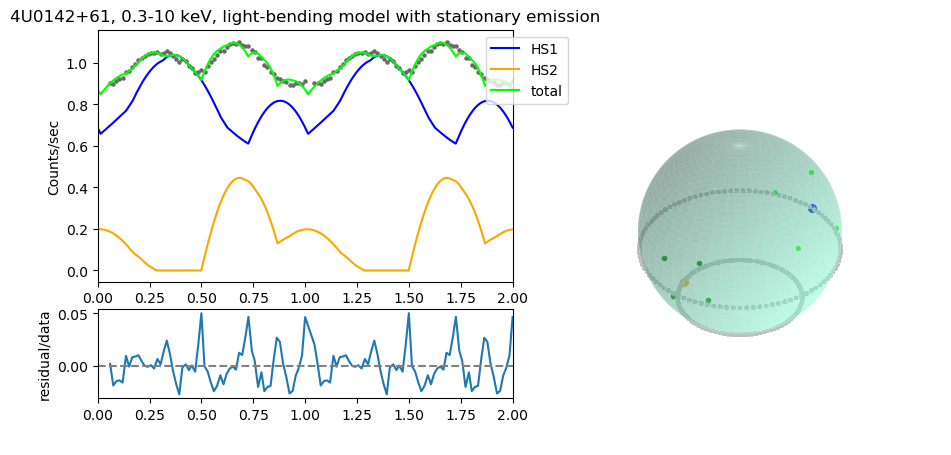

inclination angle: 35.14267231085033
Hot_spot_1: 100.60433012506059 133.19263225959907 1.6403853595315696
Hot_spot_1_sub: 25.698291689642204 0.3504632338376539
Hot_spot_2: 141.86393242192003 245.98662863745523 3.1495614268723715
Hot_spot_1_sub: 17.64082584521113 0.31491545117824266


In [3]:
# 4U0142+61_0.3-10keV.csv fitting
# HS1,2 with stationary emission

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D


# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('4U0142+61_0.3-10keV.csv', header = 0)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]



# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(35)
# HS1
theta_1_main_ini = np.radians(128)
phi_1_main_ini = np.radians(110)
m_1_main_ini = 3.4
ang_1_sub_ini = np.radians(10)
m_1_sub_ini = 0.8

# HS2
theta_2_main_ini = np.radians(145)
phi_2_main_ini = np.radians(250)
m_2_main_ini = 7
ang_2_sub_ini = np.radians(10)
m_2_sub_ini = 2

# light-bending factor
f_lb = 1. / 3.


#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(2 * math.pi * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(z_rot, np.dot(y_rot, xyz))
    return XYZ_after_rotation

#############################################################################################

def HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    x_hs_1_sub_1 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(0))
    y_hs_1_sub_1 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(0))
    z_hs_1_sub_1 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_2 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(90))
    y_hs_1_sub_2 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(90))
    z_hs_1_sub_2 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_3 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(180))
    y_hs_1_sub_3 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(180))
    z_hs_1_sub_3 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_4 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(270))
    y_hs_1_sub_4 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(270))
    z_hs_1_sub_4 = polar_to_rectangular_z(ang_1_sub_ini)

    hs_1_sub_XYZ_1 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_1, y_hs_1_sub_1, z_hs_1_sub_1)
    hs_1_sub_XYZ_2 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_2, y_hs_1_sub_2, z_hs_1_sub_2)
    hs_1_sub_XYZ_3 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_3, y_hs_1_sub_3, z_hs_1_sub_3)
    hs_1_sub_XYZ_4 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_4, y_hs_1_sub_4, z_hs_1_sub_4)

    theta_1_sub_1 = rectangular_to_polar_theta(hs_1_sub_XYZ_1[2, 0])
    phi_1_sub_1 = rectangular_to_polar_phi(hs_1_sub_XYZ_1[1, 0], hs_1_sub_XYZ_1[0, 0])
    theta_1_sub_2 = rectangular_to_polar_theta(hs_1_sub_XYZ_2[2, 0])
    phi_1_sub_2 = rectangular_to_polar_phi(hs_1_sub_XYZ_2[1, 0], hs_1_sub_XYZ_2[0, 0])
    theta_1_sub_3 = rectangular_to_polar_theta(hs_1_sub_XYZ_3[2, 0])
    phi_1_sub_3 = rectangular_to_polar_phi(hs_1_sub_XYZ_3[1, 0], hs_1_sub_XYZ_3[0, 0])
    theta_1_sub_4 = rectangular_to_polar_theta(hs_1_sub_XYZ_4[2, 0])
    phi_1_sub_4 = rectangular_to_polar_phi(hs_1_sub_XYZ_4[1, 0], hs_1_sub_XYZ_4[0, 0])

    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
          mu(x, i, theta_1_sub_1, phi_1_sub_1, m_1_sub_ini) + \
          mu(x, i, theta_1_sub_2, phi_1_sub_2, m_1_sub_ini) + \
          mu(x, i, theta_1_sub_3, phi_1_sub_3, m_1_sub_ini) + \
          mu(x, i, theta_1_sub_4, phi_1_sub_4, m_1_sub_ini)
    return HS1

def HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    x_hs_2_sub_1 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(0))
    y_hs_2_sub_1 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(0))
    z_hs_2_sub_1 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_2 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(90))
    y_hs_2_sub_2 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(90))
    z_hs_2_sub_2 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_3 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(180))
    y_hs_2_sub_3 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(180))
    z_hs_2_sub_3 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_4 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(270))
    y_hs_2_sub_4 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(270))
    z_hs_2_sub_4 = polar_to_rectangular_z(ang_2_sub_ini)

    hs_2_sub_XYZ_1 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_1, y_hs_2_sub_1, z_hs_2_sub_1)
    hs_2_sub_XYZ_2 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_2, y_hs_2_sub_2, z_hs_2_sub_2)
    hs_2_sub_XYZ_3 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_3, y_hs_2_sub_3, z_hs_2_sub_3)
    hs_2_sub_XYZ_4 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_4, y_hs_2_sub_4, z_hs_2_sub_4)

    theta_2_sub_1 = rectangular_to_polar_theta(hs_2_sub_XYZ_1[2, 0])
    phi_2_sub_1 = rectangular_to_polar_phi(hs_2_sub_XYZ_1[1, 0], hs_2_sub_XYZ_1[0, 0])
    theta_2_sub_2 = rectangular_to_polar_theta(hs_2_sub_XYZ_2[2, 0])
    phi_2_sub_2 = rectangular_to_polar_phi(hs_2_sub_XYZ_2[1, 0], hs_2_sub_XYZ_2[0, 0])
    theta_2_sub_3 = rectangular_to_polar_theta(hs_2_sub_XYZ_3[2, 0])
    phi_2_sub_3 = rectangular_to_polar_phi(hs_2_sub_XYZ_3[1, 0], hs_2_sub_XYZ_3[0, 0])
    theta_2_sub_4 = rectangular_to_polar_theta(hs_2_sub_XYZ_4[2, 0])
    phi_2_sub_4 = rectangular_to_polar_phi(hs_2_sub_XYZ_4[1, 0], hs_2_sub_XYZ_4[0, 0])

    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini) + \
          mu(x, i, theta_2_sub_1, phi_2_sub_1, m_2_sub_ini) + \
          mu(x, i, theta_2_sub_2, phi_2_sub_2, m_2_sub_ini) + \
          mu(x, i, theta_2_sub_3, phi_2_sub_3, m_2_sub_ini) + \
          mu(x, i, theta_2_sub_4, phi_2_sub_4, m_2_sub_ini)
    return HS2


def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS1 sub
    x_hs_1_sub_1 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(0))
    y_hs_1_sub_1 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(0))
    z_hs_1_sub_1 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_2 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(90))
    y_hs_1_sub_2 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(90))
    z_hs_1_sub_2 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_3 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(180))
    y_hs_1_sub_3 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(180))
    z_hs_1_sub_3 = polar_to_rectangular_z(ang_1_sub_ini)
    x_hs_1_sub_4 = polar_to_rectangular_x(ang_1_sub_ini, np.radians(270))
    y_hs_1_sub_4 = polar_to_rectangular_y(ang_1_sub_ini, np.radians(270))
    z_hs_1_sub_4 = polar_to_rectangular_z(ang_1_sub_ini)

    hs_1_sub_XYZ_1 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_1, y_hs_1_sub_1, z_hs_1_sub_1)
    hs_1_sub_XYZ_2 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_2, y_hs_1_sub_2, z_hs_1_sub_2)
    hs_1_sub_XYZ_3 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_3, y_hs_1_sub_3, z_hs_1_sub_3)
    hs_1_sub_XYZ_4 = rotation_matrix(theta_1_main_ini, phi_1_main_ini, x_hs_1_sub_4, y_hs_1_sub_4, z_hs_1_sub_4)

    theta_1_sub_1 = rectangular_to_polar_theta(hs_1_sub_XYZ_1[2, 0])
    phi_1_sub_1 = rectangular_to_polar_phi(hs_1_sub_XYZ_1[1, 0], hs_1_sub_XYZ_1[0, 0])
    theta_1_sub_2 = rectangular_to_polar_theta(hs_1_sub_XYZ_2[2, 0])
    phi_1_sub_2 = rectangular_to_polar_phi(hs_1_sub_XYZ_2[1, 0], hs_1_sub_XYZ_2[0, 0])
    theta_1_sub_3 = rectangular_to_polar_theta(hs_1_sub_XYZ_3[2, 0])
    phi_1_sub_3 = rectangular_to_polar_phi(hs_1_sub_XYZ_3[1, 0], hs_1_sub_XYZ_3[0, 0])
    theta_1_sub_4 = rectangular_to_polar_theta(hs_1_sub_XYZ_4[2, 0])
    phi_1_sub_4 = rectangular_to_polar_phi(hs_1_sub_XYZ_4[1, 0], hs_1_sub_XYZ_4[0, 0])
    
    # HS2 sub
    x_hs_2_sub_1 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(0))
    y_hs_2_sub_1 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(0))
    z_hs_2_sub_1 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_2 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(90))
    y_hs_2_sub_2 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(90))
    z_hs_2_sub_2 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_3 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(180))
    y_hs_2_sub_3 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(180))
    z_hs_2_sub_3 = polar_to_rectangular_z(ang_2_sub_ini)
    x_hs_2_sub_4 = polar_to_rectangular_x(ang_2_sub_ini, np.radians(270))
    y_hs_2_sub_4 = polar_to_rectangular_y(ang_2_sub_ini, np.radians(270))
    z_hs_2_sub_4 = polar_to_rectangular_z(ang_2_sub_ini)

    hs_2_sub_XYZ_1 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_1, y_hs_2_sub_1, z_hs_2_sub_1)
    hs_2_sub_XYZ_2 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_2, y_hs_2_sub_2, z_hs_2_sub_2)
    hs_2_sub_XYZ_3 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_3, y_hs_2_sub_3, z_hs_2_sub_3)
    hs_2_sub_XYZ_4 = rotation_matrix(theta_2_main_ini, phi_2_main_ini, x_hs_2_sub_4, y_hs_2_sub_4, z_hs_2_sub_4)

    theta_2_sub_1 = rectangular_to_polar_theta(hs_2_sub_XYZ_1[2, 0])
    phi_2_sub_1 = rectangular_to_polar_phi(hs_2_sub_XYZ_1[1, 0], hs_2_sub_XYZ_1[0, 0])
    theta_2_sub_2 = rectangular_to_polar_theta(hs_2_sub_XYZ_2[2, 0])
    phi_2_sub_2 = rectangular_to_polar_phi(hs_2_sub_XYZ_2[1, 0], hs_2_sub_XYZ_2[0, 0])
    theta_2_sub_3 = rectangular_to_polar_theta(hs_2_sub_XYZ_3[2, 0])
    phi_2_sub_3 = rectangular_to_polar_phi(hs_2_sub_XYZ_3[1, 0], hs_2_sub_XYZ_3[0, 0])
    theta_2_sub_4 = rectangular_to_polar_theta(hs_2_sub_XYZ_4[2, 0])
    phi_2_sub_4 = rectangular_to_polar_phi(hs_2_sub_XYZ_4[1, 0], hs_2_sub_XYZ_4[0, 0])
    
    # total
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_1_sub_1, phi_1_sub_1, m_1_sub_ini) + \
            mu(x, i, theta_1_sub_2, phi_1_sub_2, m_1_sub_ini) + \
            mu(x, i, theta_1_sub_3, phi_1_sub_3, m_1_sub_ini) + \
            mu(x, i, theta_1_sub_4, phi_1_sub_4, m_1_sub_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini) + \
            mu(x, i, theta_2_sub_1, phi_2_sub_1, m_2_sub_ini) + \
            mu(x, i, theta_2_sub_2, phi_2_sub_2, m_2_sub_ini) + \
            mu(x, i, theta_2_sub_3, phi_2_sub_3, m_2_sub_ini) + \
            mu(x, i, theta_2_sub_4, phi_2_sub_4, m_2_sub_ini)
    
    return Total

x = np.linspace(0, 2, 5000)





# fitting
# parameter_initial = np.array([-1.5, 1, 0.2, 4000])
# parameter_initial_2 = np.array([-1.5, 1, 0.2, 4000])
parameter_initial_3 = np.array([i_ini, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini])

# parameter_initial_4 = np.array([-1.5, 1, 0.2, 4000])

# parameter_optimal, covariance = scipy.optimize.curve_fit(func_3, x_data, y_data, p0 = parameter_initial_3)


# parameter_optimal, covariance = scipy.optimize.curve_fit(mu_total, x_data, y_data, p0 = parameter_initial_3, \
#                                                         bounds = ((0, 0, 0, 0, 7, 0, 0, 0, 0, 7, 0), \
#                                                                   (90, 360, 180, 100, 20.5, 10, 90, 360, 100, 20.5, 10)))

parameter_optimal, covariance = scipy.optimize.curve_fit(mu_total, x_data, y_data, p0 = parameter_initial_3)

print(parameter_optimal)

# y_fitting = func_3(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9])
# y_fitting_same_size_as_y_data = func_3(x_data, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9])
y_fitting = mu_total(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])
y_fitting_same_size_as_y_data = mu_total(x_data, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])



# trajectory of HS
x_track_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.cos(theta_sphere)
y_track_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.sin(theta_sphere)
z_track_hs_1 = scale * r * np.cos(parameter_optimal[1])
x_track_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.cos(theta_sphere)
y_track_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.sin(theta_sphere)
z_track_hs_2 = scale * r * np.cos(parameter_optimal[6])
ax2.scatter(x_track_hs_1, y_track_hs_1, z_track_hs_1, s = 3, color = "silver")
ax2.scatter(x_track_hs_2, y_track_hs_2, z_track_hs_2, s = 3, color = "silver")

# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.cos(parameter_optimal[2])
x_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.cos(parameter_optimal[7])
y_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.sin(parameter_optimal[2])
y_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.sin(parameter_optimal[7])
z_hs_1 = scale * r * np.cos(parameter_optimal[1])
z_hs_2 = scale * r * np.cos(parameter_optimal[6])

x_hs = [x_hs_1, x_hs_2]
y_hs = [y_hs_1, y_hs_2]
z_hs = [z_hs_1, z_hs_2]

HS_main_plot_size = 30
HS_sub_plot_size_1 = m_1_sub_ini / m_1_main_ini * HS_main_plot_size
HS_sub_plot_size_2 = m_2_sub_ini / m_2_main_ini * HS_main_plot_size

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "blue")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "orange")



# positions of HS_sub
# HS1 sub
x_hs_1_sub_1 = polar_to_rectangular_x(parameter_optimal[4], np.radians(0))
y_hs_1_sub_1 = polar_to_rectangular_y(parameter_optimal[4], np.radians(0))
z_hs_1_sub_1 = polar_to_rectangular_z(parameter_optimal[4])
x_hs_1_sub_2 = polar_to_rectangular_x(parameter_optimal[4], np.radians(90))
y_hs_1_sub_2 = polar_to_rectangular_y(parameter_optimal[4], np.radians(90))
z_hs_1_sub_2 = polar_to_rectangular_z(parameter_optimal[4])
x_hs_1_sub_3 = polar_to_rectangular_x(parameter_optimal[4], np.radians(180))
y_hs_1_sub_3 = polar_to_rectangular_y(parameter_optimal[4], np.radians(180))
z_hs_1_sub_3 = polar_to_rectangular_z(parameter_optimal[4])
x_hs_1_sub_4 = polar_to_rectangular_x(parameter_optimal[4], np.radians(270))
y_hs_1_sub_4 = polar_to_rectangular_y(parameter_optimal[4], np.radians(270))
z_hs_1_sub_4 = polar_to_rectangular_z(parameter_optimal[4])

hs_1_sub_XYZ_1 = rotation_matrix(parameter_optimal[1], parameter_optimal[2], x_hs_1_sub_1, y_hs_1_sub_1, z_hs_1_sub_1)
hs_1_sub_XYZ_2 = rotation_matrix(parameter_optimal[1], parameter_optimal[2], x_hs_1_sub_2, y_hs_1_sub_2, z_hs_1_sub_2)
hs_1_sub_XYZ_3 = rotation_matrix(parameter_optimal[1], parameter_optimal[2], x_hs_1_sub_3, y_hs_1_sub_3, z_hs_1_sub_3)
hs_1_sub_XYZ_4 = rotation_matrix(parameter_optimal[1], parameter_optimal[2], x_hs_1_sub_4, y_hs_1_sub_4, z_hs_1_sub_4)

# HS2 sub
x_hs_2_sub_1 = polar_to_rectangular_x(parameter_optimal[9], np.radians(0))
y_hs_2_sub_1 = polar_to_rectangular_y(parameter_optimal[9], np.radians(0))
z_hs_2_sub_1 = polar_to_rectangular_z(parameter_optimal[9])
x_hs_2_sub_2 = polar_to_rectangular_x(parameter_optimal[9], np.radians(90))
y_hs_2_sub_2 = polar_to_rectangular_y(parameter_optimal[9], np.radians(90))
z_hs_2_sub_2 = polar_to_rectangular_z(parameter_optimal[9])
x_hs_2_sub_3 = polar_to_rectangular_x(parameter_optimal[9], np.radians(180))
y_hs_2_sub_3 = polar_to_rectangular_y(parameter_optimal[9], np.radians(180))
z_hs_2_sub_3 = polar_to_rectangular_z(parameter_optimal[9])
x_hs_2_sub_4 = polar_to_rectangular_x(parameter_optimal[9], np.radians(270))
y_hs_2_sub_4 = polar_to_rectangular_y(parameter_optimal[9], np.radians(270))
z_hs_2_sub_4 = polar_to_rectangular_z(parameter_optimal[9])

hs_2_sub_XYZ_1 = rotation_matrix(parameter_optimal[6], parameter_optimal[7], x_hs_2_sub_1, y_hs_2_sub_1, z_hs_2_sub_1)
hs_2_sub_XYZ_2 = rotation_matrix(parameter_optimal[6], parameter_optimal[7], x_hs_2_sub_2, y_hs_2_sub_2, z_hs_2_sub_2)
hs_2_sub_XYZ_3 = rotation_matrix(parameter_optimal[6], parameter_optimal[7], x_hs_2_sub_3, y_hs_2_sub_3, z_hs_2_sub_3)
hs_2_sub_XYZ_4 = rotation_matrix(parameter_optimal[6], parameter_optimal[7], x_hs_2_sub_4, y_hs_2_sub_4, z_hs_2_sub_4)

ax2.scatter(hs_1_sub_XYZ_1[0, 0], hs_1_sub_XYZ_1[1, 0], hs_1_sub_XYZ_1[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_1_sub_XYZ_2[0, 0], hs_1_sub_XYZ_2[1, 0], hs_1_sub_XYZ_2[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_1_sub_XYZ_3[0, 0], hs_1_sub_XYZ_3[1, 0], hs_1_sub_XYZ_3[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_1_sub_XYZ_4[0, 0], hs_1_sub_XYZ_4[1, 0], hs_1_sub_XYZ_4[2, 0], zorder = 3, s = HS_sub_plot_size_1, c = "lime")
ax2.scatter(hs_2_sub_XYZ_1[0, 0], hs_2_sub_XYZ_1[1, 0], hs_2_sub_XYZ_1[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "green")
ax2.scatter(hs_2_sub_XYZ_2[0, 0], hs_2_sub_XYZ_2[1, 0], hs_2_sub_XYZ_2[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "green")
ax2.scatter(hs_2_sub_XYZ_3[0, 0], hs_2_sub_XYZ_3[1, 0], hs_2_sub_XYZ_3[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "green")
ax2.scatter(hs_2_sub_XYZ_4[0, 0], hs_2_sub_XYZ_4[1, 0], hs_2_sub_XYZ_4[2, 0], zorder = 3, s = HS_sub_plot_size_2, c = "green")



HS1 = mu_HS1(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5])
HS2 = mu_HS2(x, parameter_optimal[0], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])



# data of pulse profile
ax1.scatter(x_data, y_data, s = 5, c = "dimgrey")
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", color = "blue")
ax1.plot(x, HS2, label = "HS2", color = "orange")
ax1.plot(x, y_fitting, label = 'total', color = 'lime')
# info
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("4U0142+61, 0.3-10 keV, light-bending model with stationary emission")
# ax.text(1.8, 0.325, r"$\theta = \frac{\pi}{5}$")
# ax.text(1.8, 0.31, r"$i = \frac{\pi}{3}$")
# ax.text(1.8, 0.295, r"$\phi = \pi$")
# ax.text(0.8, 0.32, r"$amp = 0.345$")
# plt.title("3XMM J185246.6+003317のパルス波形と手合わせ曲線", fontname = "MS Gothic")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = np.degrees(parameter_optimal[0]), azim = 0)
ax2.axis("off")

# ax3.plot(x_data, y_data - func(x_data, a_p_1, b, c_p_1, d_p_1) - func(x_data, a_p_2, b, c_p_2, d_p_2) - func(x_data, a_p_3, b, c_p_3, d_p_3))
ax3.plot(x_data, (y_data - y_fitting_same_size_as_y_data) / y_data)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("inclination angle:", np.degrees(parameter_optimal[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal[1]), np.degrees(parameter_optimal[2]), parameter_optimal[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal[4]), parameter_optimal[5])
print("Hot_spot_2:", np.degrees(parameter_optimal[6]), np.degrees(parameter_optimal[7]), parameter_optimal[8])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal[9]), parameter_optimal[10])

36.0
36
0.0
6.283185307179586
[[ 0.98998516 -0.55012813 -0.45110134 -0.38806508 -0.38509706 -0.44333097
  -0.54052343 -0.63955023 -0.70258649 -0.7055545  -0.64732059]
 [ 0.98998516  0.83239244  0.89584533  0.93228586  0.92779499  0.88408808
   0.81785967  0.75440678  0.71796624  0.72245712  0.76616403]
 [ 0.98998516  0.15678606  0.11861166  0.01866979 -0.10486516 -0.20480703
  -0.24298143 -0.20480703 -0.10486516  0.01866979  0.11861166]]


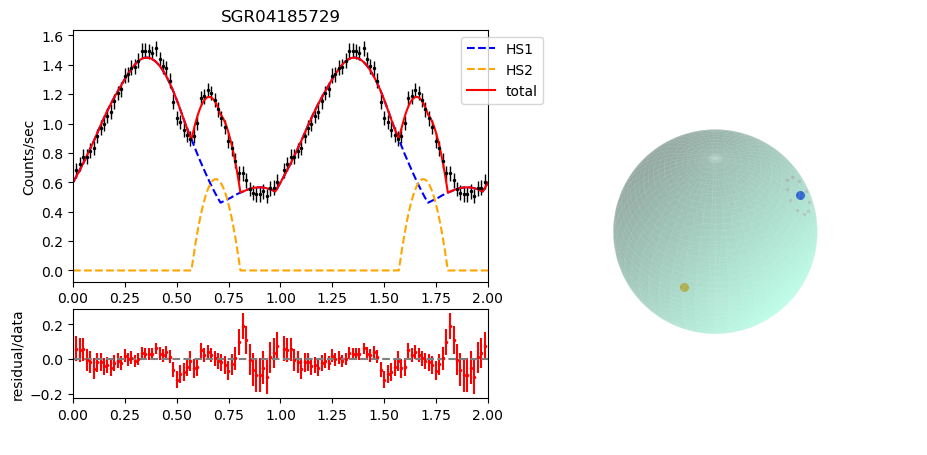

FITTING
inclination angle: 44.03193606780428
Hot_spot_1: 92.49508398563405 123.46071462935926 1.4311042001578378
Hot_spot_1_sub: -11.425435635884943 0.10324518323561034
Hot_spot_2: 159.97073575934246 247.90841166413153 14.895465501305877
Hot_spot_2_sub: 136.68253288589 -6.693975000073149e-05
REDUCED CHI SQUARE:
1.075193344420939


In [5]:
# SGR 0418+5729
# HS1,2 finite spots
# error fitting (Poission distribution), errorbar plot

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import scipy.stats
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D
import random

# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('SGR0148+5729_230307.csv', header = 0)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]

# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(44)
# HS1
theta_1_main_ini = np.radians(92)
phi_1_main_ini = np.radians(124)
m_1_main_ini = 1.4
ang_1_sub_ini = np.radians(11)
m_1_sub_ini = 0.1

# HS2
theta_2_main_ini = np.radians(160)
phi_2_main_ini = np.radians(249)
m_2_main_ini = 14
ang_2_sub_ini = np.radians(15)
m_2_sub_ini = 0.01

# light-bending factor
f_lb = 1. / 3.

# sub_hot_spot_number
N_sub = 10

print(360 / N_sub)
print(int(360 / N_sub))
print(360 / N_sub - int(360 / N_sub))

pi_times_2 = 2. * math.pi
print(pi_times_2)

#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(pi_times_2 * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(z_rot, np.dot(y_rot, xyz))
    return XYZ_after_rotation

def sub_hot_spot_hs(N_sub, ang, theta_main, phi_main):
    delta_phi = 360 / N_sub
    temp_phi = 0
    x_hs_sub = np.empty(0)
    y_hs_sub = np.empty(0)
    z_hs_sub = np.empty(0)
    for i in range(0, N_sub):
        x_hs_sub = np.append(x_hs_sub, polar_to_rectangular_x(ang, np.radians(temp_phi)))
        y_hs_sub = np.append(y_hs_sub, polar_to_rectangular_y(ang, np.radians(temp_phi)))
        z_hs_sub = np.append(z_hs_sub, polar_to_rectangular_z(ang))
        temp_phi += delta_phi
    hs_sub_XYZ = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_XYZ = np.append(hs_sub_XYZ, rotation_matrix(theta_main, phi_main, x_hs_sub[i], y_hs_sub[i], z_hs_sub[i]), axis = 1)
    hs_sub_theta = np.empty(0)
    hs_sub_phi = np.empty(0)
    for i in range(0, N_sub):
        hs_sub_theta = np.append(hs_sub_theta, rectangular_to_polar_theta(hs_sub_XYZ[2, i]))
        hs_sub_phi = np.append(hs_sub_phi, rectangular_to_polar_phi(hs_sub_XYZ[1, i], hs_sub_XYZ[0, i]))
    return hs_sub_XYZ, hs_sub_theta, hs_sub_phi

# def calculate_reduced_chi_square(data, model):
#     RCS = scipy.stats.chisquare(data, model)
#     return RCS

def calculate_reduced_chi_square(observed_data, model_predictions, uncertainty, degrees_of_freedom):
    number_of_observations = len(observed_data)
    chi_square = 0
    for i in range(0, number_of_observations):
        chi_square += (observed_data[i] - model_predictions[i]) ** 2 / uncertainty ** 2
    reduced_chi_square = chi_square / (number_of_observations - degrees_of_freedom)
    return reduced_chi_square
    
    
#############################################################################################

def HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini)
    for i in range(0, N_sub):
        HS1 += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
    return HS1

def HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        HS2 += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return HS2


def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    # total
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        Total += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
        Total += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return Total

x = np.linspace(0, 2, 5000)


data_uncertainty = np.empty(0)
for i in range(0, len(y_data)):
    data_uncertainty = np.append(data_uncertainty, 0.05)

###################################################
###################################################
##################### fitting #####################
###################################################
###################################################

parameter_initial = np.array([i_ini, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini])
# parameter_initial_test_gen = np.array([inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen])
# parameter_initial_test_gen_ini = np.array([inc_gen_ini, theta_1_main_gen_ini, phi_1_main_gen_ini, m_1_main_gen_ini, ang_1_sub_gen_ini, m_1_sub_gen_ini, theta_2_main_gen_ini, phi_2_main_gen_ini, m_2_main_gen_ini, ang_2_sub_gen_ini, m_2_sub_gen_ini])

# parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, p0 = parameter_initial_test_gen)
parameter_optimal, covariance = scipy.optimize.curve_fit(mu_total, x_data, y_data, sigma = data_uncertainty, p0 = parameter_initial)

# y_fitting_gen = mu_total(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
# y_fitting_same_size_as_y_data_gen = mu_total(x_pf_data_gen_pandas, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
y_fitting = mu_total(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])
y_fitting_same_size_as_y_data = mu_total(x_data, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])



# reduced X^2
reduced_chi_square_gen_data_fit = calculate_reduced_chi_square(y_data, y_fitting_same_size_as_y_data, 0.05, 11)

###################################################
###################################################
#################### draw pic #####################
###################################################
###################################################

# draw positon of main
# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.cos(parameter_optimal[2])
x_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.cos(parameter_optimal[7])
y_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.sin(parameter_optimal[2])
y_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.sin(parameter_optimal[7])
z_hs_1 = scale * r * np.cos(parameter_optimal[1])
z_hs_2 = scale * r * np.cos(parameter_optimal[6])

x_hs = [x_hs_1, x_hs_2]
y_hs = [y_hs_1, y_hs_2]
z_hs = [z_hs_1, z_hs_2]

HS_main_plot_size = 30

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "blue")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "orange")

HS_sub_plot_size_1 = parameter_optimal[5] / parameter_optimal[3] * HS_main_plot_size
HS_sub_plot_size_2 = parameter_optimal[10] / parameter_optimal[8] * HS_main_plot_size

# function maybe useless, for maybe this func is repeating some of the funcs already been coded before
def drawing_sub_hs(theta_sub_fit, N_sub, theta_main_fit, phi_main_fit):
    x_draw = np.empty(0)
    y_draw = np.empty(0)
    z_draw = np.empty(0)
    for i in range(0, N_sub):
        x_draw = np.append(x_draw, polar_to_rectangular_x(theta_sub_fit, np.radians(i * 360 / N_sub)))
        y_draw = np.append(y_draw, polar_to_rectangular_y(theta_sub_fit, np.radians(i * 360 / N_sub)))
        z_draw = np.append(z_draw, polar_to_rectangular_z(theta_sub_fit))
    hs_sub_draw = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_draw = np.append(hs_sub_draw, rotation_matrix(theta_main_fit, phi_main_fit, x_draw[i], y_draw[i], z_draw[i]), axis = 1)
    return hs_sub_draw

hs_sub_draw_1 = drawing_sub_hs(parameter_optimal[4], N_sub, parameter_optimal[1], parameter_optimal[2])
print(hs_sub_draw_1)
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_1[0, i+1], hs_sub_draw_1[1, i+1], hs_sub_draw_1[2, i+1], zorder = 3, s = HS_sub_plot_size_1, c = "pink")

hs_sub_draw_2 = drawing_sub_hs(parameter_optimal[9], N_sub, parameter_optimal[6], parameter_optimal[7])
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_2[0, i+1], hs_sub_draw_2[1, i+1], hs_sub_draw_2[2, i+1], zorder = 3, s = HS_sub_plot_size_2, c = "blue")

HS1 = HS1(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5])
HS2 = HS2(x, parameter_optimal[0], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])


for i in range(0, len(y_data)):
    x_data = np.append(x_data, x_data[i] + 1)
    y_data = np.append(y_data, y_data[i])
#     poission_error = np.append(poission_error, poission_error[i])
    y_fitting_same_size_as_y_data = np.append(y_fitting_same_size_as_y_data, y_fitting_same_size_as_y_data[i])
# data of pulse profile
# ax1.scatter(x_pf_data_gen, gen_data, s = 5, c = "dimgrey")
# print(uncertainty)
ax1.errorbar(x_data, y_data, yerr = 0.05, fmt = "o", elinewidth = 1, c = "black", markersize = 1.5)
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", linestyle = '--', color = "blue")
ax1.plot(x, HS2, label = "HS2", linestyle = "--", color = "orange")
ax1.plot(x, y_fitting, label = 'total', color = 'red')
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("SGR04185729")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = 90 - np.degrees(parameter_optimal[0]), azim = 0)
ax2.axis("off")

ax3.errorbar(x_data, (y_data - y_fitting_same_size_as_y_data) / y_data, yerr = 0.05 / y_data, fmt = "o", elinewidth = 1.5, color = "red", markersize = 1.5)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("FITTING")
print("inclination angle:", np.degrees(parameter_optimal[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal[1]), np.degrees(parameter_optimal[2]), parameter_optimal[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal[4]), parameter_optimal[5])
print("Hot_spot_2:", np.degrees(parameter_optimal[6]), np.degrees(parameter_optimal[7]), parameter_optimal[8])
print("Hot_spot_2_sub:", np.degrees(parameter_optimal[9]), parameter_optimal[10])
print("REDUCED CHI SQUARE:")
print(reduced_chi_square_gen_data_fit)

# print("")

# print("INPUT")
# print("inclination angle:", np.degrees(inc_gen_ini))
# print("Hot_spot_1:", np.degrees(theta_1_main_gen_ini), np.degrees(phi_1_main_gen_ini), m_1_main_gen_ini)
# print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen_ini), m_1_sub_gen_ini)
# print("Hot_spot_2:", np.degrees(theta_2_main_gen_ini), np.degrees(phi_2_main_gen_ini), m_2_main_gen_ini)
# print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen_ini), m_2_sub_gen_ini)

# print("")

# print("Original")
# print("inclination angle:", np.degrees(inc_gen))
# print("Hot_spot_1:", np.degrees(theta_1_main_gen), np.degrees(phi_1_main_gen), m_1_main_gen)
# print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen), m_1_sub_gen)
# print("Hot_spot_2:", np.degrees(theta_2_main_gen), np.degrees(phi_2_main_gen), m_2_main_gen)
# print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen), m_2_sub_gen)

In [ ]:
SGR J1745-2900_xmm_epic_0.3-10keV.csv

36.0
36
0.0
6.283185307179586


/tmp/ipykernel_1540396/3824611029.py:295: RuntimeWarning: divide by zero encountered in true_divide
  ax3.errorbar(x_data, (y_data - y_fitting_same_size_as_y_data) / y_data, yerr = 0.05 / y_data, fmt = "o", elinewidth = 1.5, color = "red", markersize = 1.5)


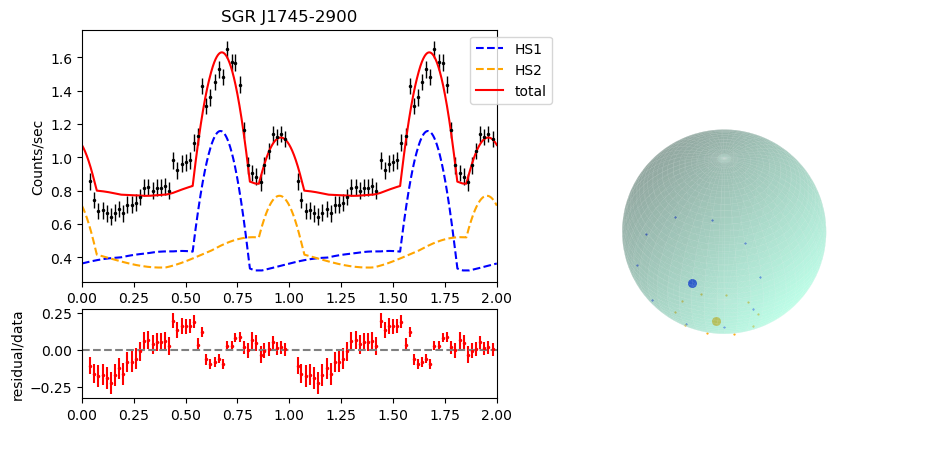

FITTING
inclination angle: 43.94797886456385
Hot_spot_1: 158.0879417956854 241.79437210346615 12.494118215068534
Hot_spot_1_sub: 40.60456854069464 0.08378509006512251
Hot_spot_2: 160.53941580083247 346.4200175802386 8.163323472778906
Hot_spot_2_sub: 24.380196694632357 0.089002695655792
REDUCED CHI SQUARE:
4.991385712372991


In [2]:
# SGR 0418+5729
# HS1,2 finite spots
# error fitting (Poission distribution), errorbar plot

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import scipy.stats
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D
import random

# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('SGR J1745-2900_xmm_epic_0.3-10keV.csv', header = 0)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]
x_data = x_data[0:int(len(x_data) / 2) - 1]
# print(x_data)
y_data = y_data[0:int(len(y_data) / 2) - 1]
# print(y_data)

# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(44)
# HS1
theta_1_main_ini = np.radians(158)
phi_1_main_ini = np.radians(241)
m_1_main_ini = 16
ang_1_sub_ini = np.radians(5)
m_1_sub_ini = 0.1

# HS2
theta_2_main_ini = np.radians(160)
phi_2_main_ini = np.radians(355)
m_2_main_ini = 10
ang_2_sub_ini = np.radians(5)
m_2_sub_ini = 0.1

# light-bending factor
f_lb = 1. / 3.

# sub_hot_spot_number
N_sub = 10

print(360 / N_sub)
print(int(360 / N_sub))
print(360 / N_sub - int(360 / N_sub))

pi_times_2 = 2. * math.pi
print(pi_times_2)

#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(pi_times_2 * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(z_rot, np.dot(y_rot, xyz))
    return XYZ_after_rotation

def sub_hot_spot_hs(N_sub, ang, theta_main, phi_main):
    delta_phi = 360 / N_sub
    temp_phi = 0
    x_hs_sub = np.empty(0)
    y_hs_sub = np.empty(0)
    z_hs_sub = np.empty(0)
    for i in range(0, N_sub):
        x_hs_sub = np.append(x_hs_sub, polar_to_rectangular_x(ang, np.radians(temp_phi)))
        y_hs_sub = np.append(y_hs_sub, polar_to_rectangular_y(ang, np.radians(temp_phi)))
        z_hs_sub = np.append(z_hs_sub, polar_to_rectangular_z(ang))
        temp_phi += delta_phi
    hs_sub_XYZ = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_XYZ = np.append(hs_sub_XYZ, rotation_matrix(theta_main, phi_main, x_hs_sub[i], y_hs_sub[i], z_hs_sub[i]), axis = 1)
    hs_sub_theta = np.empty(0)
    hs_sub_phi = np.empty(0)
    for i in range(0, N_sub):
        hs_sub_theta = np.append(hs_sub_theta, rectangular_to_polar_theta(hs_sub_XYZ[2, i]))
        hs_sub_phi = np.append(hs_sub_phi, rectangular_to_polar_phi(hs_sub_XYZ[1, i], hs_sub_XYZ[0, i]))
    return hs_sub_XYZ, hs_sub_theta, hs_sub_phi

# def calculate_reduced_chi_square(data, model):
#     RCS = scipy.stats.chisquare(data, model)
#     return RCS

def calculate_reduced_chi_square(observed_data, model_predictions, uncertainty, degrees_of_freedom):
    number_of_observations = len(observed_data)
    chi_square = 0
    for i in range(0, number_of_observations):
        chi_square += (observed_data[i] - model_predictions[i]) ** 2 / uncertainty ** 2
    reduced_chi_square = chi_square / (number_of_observations - degrees_of_freedom)
    return reduced_chi_square
    
    
#############################################################################################

def HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini)
    for i in range(0, N_sub):
        HS1 += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
    return HS1

def HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        HS2 += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return HS2


def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    # total
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        Total += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
        Total += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return Total

x = np.linspace(0, 2, 5000)


data_uncertainty = np.empty(0)
for i in range(0, len(y_data)):
    data_uncertainty = np.append(data_uncertainty, 0.05)

###################################################
###################################################
##################### fitting #####################
###################################################
###################################################

parameter_initial = np.array([i_ini, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini])
# parameter_initial_test_gen = np.array([inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen])
# parameter_initial_test_gen_ini = np.array([inc_gen_ini, theta_1_main_gen_ini, phi_1_main_gen_ini, m_1_main_gen_ini, ang_1_sub_gen_ini, m_1_sub_gen_ini, theta_2_main_gen_ini, phi_2_main_gen_ini, m_2_main_gen_ini, ang_2_sub_gen_ini, m_2_sub_gen_ini])

# parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, p0 = parameter_initial_test_gen)
parameter_optimal, covariance = scipy.optimize.curve_fit(mu_total, x_data, y_data, sigma = data_uncertainty, p0 = parameter_initial)

# y_fitting_gen = mu_total(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
# y_fitting_same_size_as_y_data_gen = mu_total(x_pf_data_gen_pandas, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
y_fitting = mu_total(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])
y_fitting_same_size_as_y_data = mu_total(x_data, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])



# reduced X^2
reduced_chi_square_gen_data_fit = calculate_reduced_chi_square(y_data, y_fitting_same_size_as_y_data, 0.05, 11)

###################################################
###################################################
#################### draw pic #####################
###################################################
###################################################

# draw positon of main
# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.cos(parameter_optimal[2])
x_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.cos(parameter_optimal[7])
y_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.sin(parameter_optimal[2])
y_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.sin(parameter_optimal[7])
z_hs_1 = scale * r * np.cos(parameter_optimal[1])
z_hs_2 = scale * r * np.cos(parameter_optimal[6])

x_hs = [x_hs_1, x_hs_2]
y_hs = [y_hs_1, y_hs_2]
z_hs = [z_hs_1, z_hs_2]

HS_main_plot_size = 30

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "blue")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "orange")

HS_sub_plot_size_1 = parameter_optimal[5] / parameter_optimal[3] * HS_main_plot_size
HS_sub_plot_size_2 = parameter_optimal[10] / parameter_optimal[8] * HS_main_plot_size

# function maybe useless, for maybe this func is repeating some of the funcs already been coded before
def drawing_sub_hs(theta_sub_fit, N_sub, theta_main_fit, phi_main_fit):
    x_draw = np.empty(0)
    y_draw = np.empty(0)
    z_draw = np.empty(0)
    for i in range(0, N_sub):
        x_draw = np.append(x_draw, polar_to_rectangular_x(theta_sub_fit, np.radians(i * 360 / N_sub)))
        y_draw = np.append(y_draw, polar_to_rectangular_y(theta_sub_fit, np.radians(i * 360 / N_sub)))
        z_draw = np.append(z_draw, polar_to_rectangular_z(theta_sub_fit))
    hs_sub_draw = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_draw = np.append(hs_sub_draw, rotation_matrix(theta_main_fit, phi_main_fit, x_draw[i], y_draw[i], z_draw[i]), axis = 1)
    return hs_sub_draw

hs_sub_draw_1 = drawing_sub_hs(parameter_optimal[4], N_sub, parameter_optimal[1], parameter_optimal[2])
# print(hs_sub_draw_1)
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_1[0, i+1], hs_sub_draw_1[1, i+1], hs_sub_draw_1[2, i+1], zorder = 3, s = HS_sub_plot_size_1, c = "blue")

hs_sub_draw_2 = drawing_sub_hs(parameter_optimal[9], N_sub, parameter_optimal[6], parameter_optimal[7])
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_2[0, i+1], hs_sub_draw_2[1, i+1], hs_sub_draw_2[2, i+1], zorder = 3, s = HS_sub_plot_size_2, c = "orange")

HS1 = HS1(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5])
HS2 = HS2(x, parameter_optimal[0], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])


for i in range(0, len(y_data)):
    x_data = np.append(x_data, x_data[i] + 1)
    y_data = np.append(y_data, y_data[i])
#     poission_error = np.append(poission_error, poission_error[i])
    y_fitting_same_size_as_y_data = np.append(y_fitting_same_size_as_y_data, y_fitting_same_size_as_y_data[i])
# data of pulse profile
# ax1.scatter(x_pf_data_gen, gen_data, s = 5, c = "dimgrey")
# print(uncertainty)
ax1.errorbar(x_data, y_data, yerr = 0.05, fmt = "o", elinewidth = 1, c = "black", markersize = 1.5)
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", linestyle = '--', color = "blue")
ax1.plot(x, HS2, label = "HS2", linestyle = "--", color = "orange")
ax1.plot(x, y_fitting, label = 'total', color = 'red')
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("SGR J1745-2900")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = 90 - np.degrees(parameter_optimal[0]), azim = 0)
ax2.axis("off")

ax3.errorbar(x_data, (y_data - y_fitting_same_size_as_y_data) / y_data, yerr = 0.05 / y_data, fmt = "o", elinewidth = 1.5, color = "red", markersize = 1.5)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("FITTING")
print("inclination angle:", np.degrees(parameter_optimal[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal[1]), np.degrees(parameter_optimal[2]), parameter_optimal[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal[4]), parameter_optimal[5])
print("Hot_spot_2:", np.degrees(parameter_optimal[6]), np.degrees(parameter_optimal[7]), parameter_optimal[8])
print("Hot_spot_2_sub:", np.degrees(parameter_optimal[9]), parameter_optimal[10])
print("REDUCED CHI SQUARE:")
print(reduced_chi_square_gen_data_fit)

# print("")

# print("INPUT")
# print("inclination angle:", np.degrees(inc_gen_ini))
# print("Hot_spot_1:", np.degrees(theta_1_main_gen_ini), np.degrees(phi_1_main_gen_ini), m_1_main_gen_ini)
# print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen_ini), m_1_sub_gen_ini)
# print("Hot_spot_2:", np.degrees(theta_2_main_gen_ini), np.degrees(phi_2_main_gen_ini), m_2_main_gen_ini)
# print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen_ini), m_2_sub_gen_ini)

# print("")

# print("Original")
# print("inclination angle:", np.degrees(inc_gen))
# print("Hot_spot_1:", np.degrees(theta_1_main_gen), np.degrees(phi_1_main_gen), m_1_main_gen)
# print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen), m_1_sub_gen)
# print("Hot_spot_2:", np.degrees(theta_2_main_gen), np.degrees(phi_2_main_gen), m_2_main_gen)
# print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen), m_2_sub_gen)

36.0
36
0.0
6.283185307179586


/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/tmp/ipykernel_1541679/268291242.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  phi_polar = np.arctan(y / x)
/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/tmp/ipykernel_1541679/268291242.py:324: RuntimeWarning: divide by zero encountered in true_divide
  ax3.errorbar(x_data, (y_data - y_fitting_same_size_as_y_data) / y_data, yerr = 0.05 / y_data, fmt = "o", elinewidth = 1.5, color = "red", markersize = 1.5)


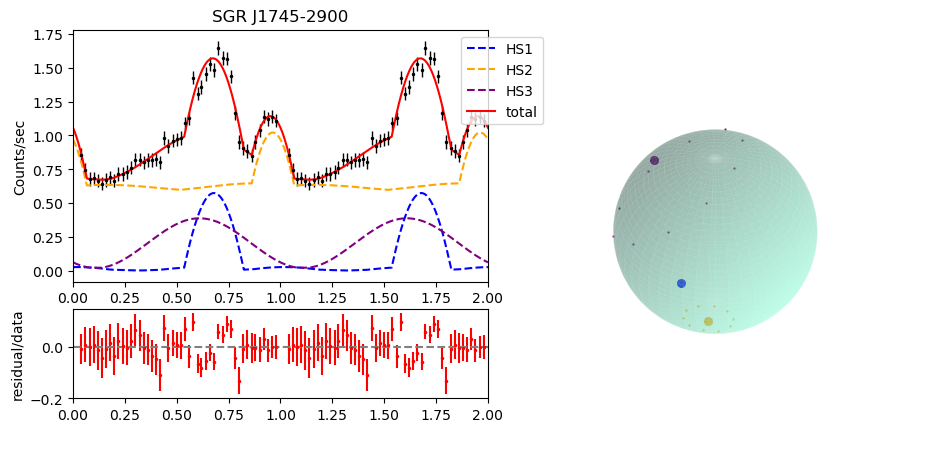

FITTING
inclination angle: 43.840328925119394
Hot_spot_1: 157.31242713979668 244.6717097006757 8.040995372040003
Hot_spot_1_sub: 755.2342236912643 -0.058974304143513484
Hot_spot_2: 160.8769937380863 347.0285616122137 12.549856233383435
Hot_spot_2_sub: -14.667357044493524 0.1314696665516276
Hot_spot_3: -76.7937372997572 38.311082214261056 0.4056454266455906
Hot_spot_3_sub: -52.51083310031969 0.00475098494220711
REDUCED CHI SQUARE:
1.8290368061755178


In [2]:
# SGR 0418+5729
# HS1,2,3 finite spots
# error fitting (Poission distribution), errorbar plot

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import scipy.stats
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D
import random

# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('SGR J1745-2900_xmm_epic_0.3-10keV.csv', header = 0)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]
x_data = x_data[0:int(len(x_data) / 2) - 1]
# print(x_data)
y_data = y_data[0:int(len(y_data) / 2) - 1]
# print(y_data)

# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(44)
# HS1
theta_1_main_ini = np.radians(158)
phi_1_main_ini = np.radians(241)
m_1_main_ini = 16
ang_1_sub_ini = np.radians(5)
m_1_sub_ini = 0.1

# HS2
theta_2_main_ini = np.radians(160)
phi_2_main_ini = np.radians(355)
m_2_main_ini = 10
ang_2_sub_ini = np.radians(5)
m_2_sub_ini = 0.1

# HS3
theta_3_main_ini = np.radians(25)
phi_3_main_ini = np.radians(0)
m_3_main_ini = 1
ang_3_sub_ini = np.radians(5)
m_3_sub_ini = 0.05

# light-bending factor
f_lb = 1. / 3.

# sub_hot_spot_number
N_sub = 10

print(360 / N_sub)
print(int(360 / N_sub))
print(360 / N_sub - int(360 / N_sub))

pi_times_2 = 2. * math.pi
print(pi_times_2)

#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(pi_times_2 * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(z_rot, np.dot(y_rot, xyz))
    return XYZ_after_rotation

def sub_hot_spot_hs(N_sub, ang, theta_main, phi_main):
    delta_phi = 360 / N_sub
    temp_phi = 0
    x_hs_sub = np.empty(0)
    y_hs_sub = np.empty(0)
    z_hs_sub = np.empty(0)
    for i in range(0, N_sub):
        x_hs_sub = np.append(x_hs_sub, polar_to_rectangular_x(ang, np.radians(temp_phi)))
        y_hs_sub = np.append(y_hs_sub, polar_to_rectangular_y(ang, np.radians(temp_phi)))
        z_hs_sub = np.append(z_hs_sub, polar_to_rectangular_z(ang))
        temp_phi += delta_phi
    hs_sub_XYZ = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_XYZ = np.append(hs_sub_XYZ, rotation_matrix(theta_main, phi_main, x_hs_sub[i], y_hs_sub[i], z_hs_sub[i]), axis = 1)
    hs_sub_theta = np.empty(0)
    hs_sub_phi = np.empty(0)
    for i in range(0, N_sub):
        hs_sub_theta = np.append(hs_sub_theta, rectangular_to_polar_theta(hs_sub_XYZ[2, i]))
        hs_sub_phi = np.append(hs_sub_phi, rectangular_to_polar_phi(hs_sub_XYZ[1, i], hs_sub_XYZ[0, i]))
    return hs_sub_XYZ, hs_sub_theta, hs_sub_phi

# def calculate_reduced_chi_square(data, model):
#     RCS = scipy.stats.chisquare(data, model)
#     return RCS

def calculate_reduced_chi_square(observed_data, model_predictions, uncertainty, degrees_of_freedom):
    number_of_observations = len(observed_data)
    chi_square = 0
    for i in range(0, number_of_observations):
        chi_square += (observed_data[i] - model_predictions[i]) ** 2 / uncertainty ** 2
    reduced_chi_square = chi_square / (number_of_observations - degrees_of_freedom)
    return reduced_chi_square
    
    
#############################################################################################

def HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini)
    for i in range(0, N_sub):
        HS1 += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
    return HS1

def HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        HS2 += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return HS2

def HS3(x, i, theta_3_main_ini, phi_3_main_ini, m_3_main_ini, ang_3_sub_ini, m_3_sub_ini):
    # HS2 sub
    hs_3_sub_XYZ, hs_3_sub_theta, hs_3_sub_phi = sub_hot_spot_hs(N_sub, ang_3_sub_ini, theta_3_main_ini, phi_3_main_ini)
    HS3 = mu(x, i, theta_3_main_ini, phi_3_main_ini, m_3_main_ini)
    for i in range(0, N_sub):
        HS3 += mu(x, i, hs_3_sub_theta[i], hs_3_sub_phi[i], m_3_sub_ini)
    return HS3


def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini, theta_3_main_ini, phi_3_main_ini, m_3_main_ini, ang_3_sub_ini, m_3_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    # HS3 sub
    hs_3_sub_XYZ, hs_3_sub_theta, hs_3_sub_phi = sub_hot_spot_hs(N_sub, ang_3_sub_ini, theta_3_main_ini, phi_3_main_ini)
    # total
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini) + \
            mu(x, i, theta_3_main_ini, phi_3_main_ini, m_3_main_ini)
    for i in range(0, N_sub):
        Total += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
        Total += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
        Total += mu(x, i, hs_3_sub_theta[i], hs_3_sub_phi[i], m_3_sub_ini)
    return Total

x = np.linspace(0, 2, 5000)


data_uncertainty = np.empty(0)
for i in range(0, len(y_data)):
    data_uncertainty = np.append(data_uncertainty, 0.05)

###################################################
###################################################
##################### fitting #####################
###################################################
###################################################

parameter_initial = np.array([i_ini, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini, theta_3_main_ini, phi_3_main_ini, m_3_main_ini, ang_3_sub_ini, m_3_sub_ini])
# parameter_initial_test_gen = np.array([inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen])
# parameter_initial_test_gen_ini = np.array([inc_gen_ini, theta_1_main_gen_ini, phi_1_main_gen_ini, m_1_main_gen_ini, ang_1_sub_gen_ini, m_1_sub_gen_ini, theta_2_main_gen_ini, phi_2_main_gen_ini, m_2_main_gen_ini, ang_2_sub_gen_ini, m_2_sub_gen_ini])

# parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, p0 = parameter_initial_test_gen)
parameter_optimal, covariance = scipy.optimize.curve_fit(mu_total, x_data, y_data, sigma = data_uncertainty, p0 = parameter_initial)

# y_fitting_gen = mu_total(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
# y_fitting_same_size_as_y_data_gen = mu_total(x_pf_data_gen_pandas, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
y_fitting = mu_total(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10], parameter_optimal[11], parameter_optimal[12], parameter_optimal[13], parameter_optimal[14], parameter_optimal[15])
y_fitting_same_size_as_y_data = mu_total(x_data, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10], parameter_optimal[11], parameter_optimal[12], parameter_optimal[13], parameter_optimal[14], parameter_optimal[15])



# reduced X^2
reduced_chi_square_gen_data_fit = calculate_reduced_chi_square(y_data, y_fitting_same_size_as_y_data, 0.05, 16)

###################################################
###################################################
#################### draw pic #####################
###################################################
###################################################

# draw positon of main
# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.cos(parameter_optimal[2])
x_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.cos(parameter_optimal[7])
x_hs_3 = scale * r * np.sin(parameter_optimal[11]) * np.cos(parameter_optimal[12])
y_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.sin(parameter_optimal[2])
y_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.sin(parameter_optimal[7])
y_hs_3 = scale * r * np.sin(parameter_optimal[11]) * np.sin(parameter_optimal[12])
z_hs_1 = scale * r * np.cos(parameter_optimal[1])
z_hs_2 = scale * r * np.cos(parameter_optimal[6])
z_hs_3 = scale * r * np.cos(parameter_optimal[11])

x_hs = [x_hs_1, x_hs_2, x_hs_3]
y_hs = [y_hs_1, y_hs_2, y_hs_3]
z_hs = [z_hs_1, z_hs_2, z_hs_3]

HS_main_plot_size = 30

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "blue")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "orange")
ax2.scatter(x_hs[2], y_hs[2], z_hs[2], s = HS_main_plot_size, c = "purple")

HS_sub_plot_size_1 = parameter_optimal[5] / parameter_optimal[3] * HS_main_plot_size
HS_sub_plot_size_2 = parameter_optimal[10] / parameter_optimal[8] * HS_main_plot_size
HS_sub_plot_size_3 = parameter_optimal[15] / parameter_optimal[13] * HS_main_plot_size

# function maybe useless, for maybe this func is repeating some of the funcs already been coded before
def drawing_sub_hs(theta_sub_fit, N_sub, theta_main_fit, phi_main_fit):
    x_draw = np.empty(0)
    y_draw = np.empty(0)
    z_draw = np.empty(0)
    for i in range(0, N_sub):
        x_draw = np.append(x_draw, polar_to_rectangular_x(theta_sub_fit, np.radians(i * 360 / N_sub)))
        y_draw = np.append(y_draw, polar_to_rectangular_y(theta_sub_fit, np.radians(i * 360 / N_sub)))
        z_draw = np.append(z_draw, polar_to_rectangular_z(theta_sub_fit))
    hs_sub_draw = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_draw = np.append(hs_sub_draw, rotation_matrix(theta_main_fit, phi_main_fit, x_draw[i], y_draw[i], z_draw[i]), axis = 1)
    return hs_sub_draw

hs_sub_draw_1 = drawing_sub_hs(parameter_optimal[4], N_sub, parameter_optimal[1], parameter_optimal[2])
# print(hs_sub_draw_1)
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_1[0, i+1], hs_sub_draw_1[1, i+1], hs_sub_draw_1[2, i+1], zorder = 3, s = HS_sub_plot_size_1, c = "blue")

hs_sub_draw_2 = drawing_sub_hs(parameter_optimal[9], N_sub, parameter_optimal[6], parameter_optimal[7])
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_2[0, i+1], hs_sub_draw_2[1, i+1], hs_sub_draw_2[2, i+1], zorder = 3, s = HS_sub_plot_size_2, c = "orange")

hs_sub_draw_3 = drawing_sub_hs(parameter_optimal[14], N_sub, parameter_optimal[11], parameter_optimal[12])
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_3[0, i+1], hs_sub_draw_3[1, i+1], hs_sub_draw_3[2, i+1], zorder = 3, s = HS_sub_plot_size_3, c = "purple")
    
HS1 = HS1(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5])
HS2 = HS2(x, parameter_optimal[0], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])
HS3 = HS3(x, parameter_optimal[0], parameter_optimal[11], parameter_optimal[12], parameter_optimal[13], parameter_optimal[14], parameter_optimal[15])

for i in range(0, len(y_data)):
    x_data = np.append(x_data, x_data[i] + 1)
    y_data = np.append(y_data, y_data[i])
#     poission_error = np.append(poission_error, poission_error[i])
    y_fitting_same_size_as_y_data = np.append(y_fitting_same_size_as_y_data, y_fitting_same_size_as_y_data[i])
# data of pulse profile
# ax1.scatter(x_pf_data_gen, gen_data, s = 5, c = "dimgrey")
# print(uncertainty)
ax1.errorbar(x_data, y_data, yerr = 0.05, fmt = "o", elinewidth = 1, c = "black", markersize = 1.5)
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", linestyle = '--', color = "blue")
ax1.plot(x, HS2, label = "HS2", linestyle = "--", color = "orange")
ax1.plot(x, HS3, label = "HS3", linestyle = "--", color = "purple")
ax1.plot(x, y_fitting, label = 'total', color = 'red')
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("SGR J1745-2900")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = 90 - np.degrees(parameter_optimal[0]), azim = 0)
ax2.axis("off")

ax3.errorbar(x_data, (y_data - y_fitting_same_size_as_y_data) / y_data, yerr = 0.05 / y_data, fmt = "o", elinewidth = 1.5, color = "red", markersize = 1.5)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("FITTING")
print("inclination angle:", np.degrees(parameter_optimal[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal[1]), np.degrees(parameter_optimal[2]), parameter_optimal[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal[4]), parameter_optimal[5])
print("Hot_spot_2:", np.degrees(parameter_optimal[6]), np.degrees(parameter_optimal[7]), parameter_optimal[8])
print("Hot_spot_2_sub:", np.degrees(parameter_optimal[9]), parameter_optimal[10])
print("Hot_spot_3:", np.degrees(parameter_optimal[11]), np.degrees(parameter_optimal[12]), parameter_optimal[13])
print("Hot_spot_3_sub:", np.degrees(parameter_optimal[14]), parameter_optimal[15])
print("REDUCED CHI SQUARE:")
print(reduced_chi_square_gen_data_fit)

In [1]:
print("hello, sojo")

hello, sojo


0     0.050847
1     0.100154
2     0.149461
3     0.198767
4     0.251156
5     0.300462
6     0.349769
7     0.399076
8     0.448382
9     0.497689
10    0.550077
11    0.599384
12    0.648690
13    0.697997
14    0.750385
15    0.799692
16    0.848998
17    0.901387
18    0.947612
19    1.000000
20    1.049307
21    1.098613
22    1.151002
23    1.200308
24    1.249615
25    1.298921
26    1.348228
27    1.400616
28    1.449923
29    1.499230
30    1.551618
31    1.600924
32    1.650231
33    1.699538
34    1.751926
35    1.801233
36    1.850539
37    1.899846
38    1.949153
39    2.000000
Name: 0, dtype: float64
0     0.050847
1     0.100154
2     0.149461
3     0.198767
4     0.251156
5     0.300462
6     0.349769
7     0.399076
8     0.448382
9     0.497689
10    0.550077
11    0.599384
12    0.648690
13    0.697997
14    0.750385
15    0.799692
16    0.848998
17    0.901387
18    0.947612
19    1.000000
Name: 0, dtype: float64
36.0
36
0.0
6.283185307179586


/tmp/ipykernel_1541679/1059517465.py:325: RuntimeWarning: divide by zero encountered in true_divide
  ax3.errorbar(x_data, (y_data - y_fitting_same_size_as_y_data) / y_data, yerr = 0.025 / y_data, fmt = "o", elinewidth = 1.5, color = "red", markersize = 1.5)


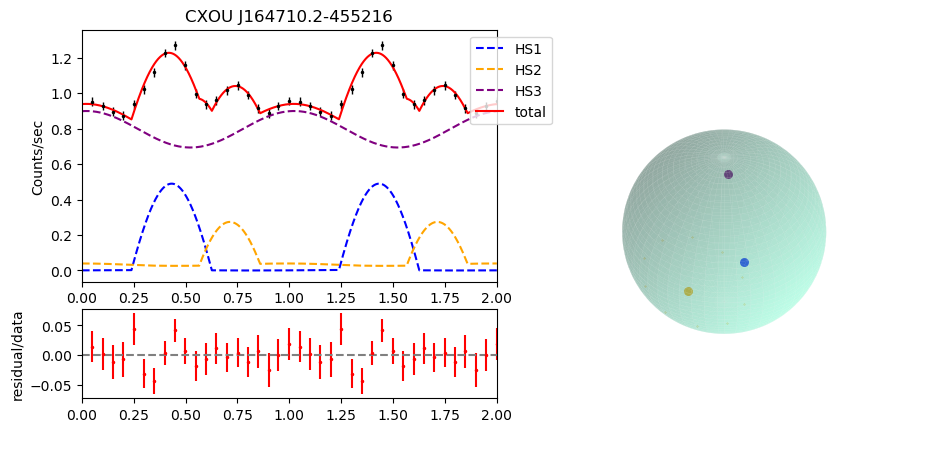

FITTING
inclination angle: 44.88292788973254
Hot_spot_1: 150.86611228546082 155.73522675490406 3.251996903598258
Hot_spot_1_sub: 96.00240084892386 -0.004129004995798278
Hot_spot_2: 158.24610815060208 256.3158875849775 3.52336289179474
Hot_spot_2_sub: -33.694287537827535 0.007273167057370569
Hot_spot_3: 12.643231819664706 8.312617267623422 1.0015631443610251
Hot_spot_3_sub: -57.83152932730545 -0.0008425965948232204
REDUCED CHI SQUARE:
3.8639253675257157


In [19]:
# SGR 0418+5729
# HS1,2,3 finite spots
# error fitting (Poission distribution), errorbar plot

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import scipy.stats
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D
import random

# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('CXOU J164710.2-455216_0.2-12keV_XISPP.csv', header = None)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]
print(x_data)
x_data = x_data[0:int(len(x_data) / 2)]
print(x_data)
y_data = y_data[0:int(len(y_data) / 2)]
# print(y_data)

# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(45)
# HS1
theta_1_main_ini = np.radians(151)
phi_1_main_ini = np.radians(155)
m_1_main_ini = 3.2
ang_1_sub_ini = np.radians(5)
m_1_sub_ini = 0

# HS2
theta_2_main_ini = np.radians(158)
phi_2_main_ini = np.radians(256)
m_2_main_ini = 3.5
ang_2_sub_ini = np.radians(5)
m_2_sub_ini = 0

# HS3
theta_3_main_ini = np.radians(11)
phi_3_main_ini = np.radians(8)
m_3_main_ini = 1
ang_3_sub_ini = np.radians(5)
m_3_sub_ini = 0

# light-bending factor
f_lb = 1. / 3.

# sub_hot_spot_number
N_sub = 10

print(360 / N_sub)
print(int(360 / N_sub))
print(360 / N_sub - int(360 / N_sub))

pi_times_2 = 2. * math.pi
print(pi_times_2)

#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(pi_times_2 * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(z_rot, np.dot(y_rot, xyz))
    return XYZ_after_rotation

def sub_hot_spot_hs(N_sub, ang, theta_main, phi_main):
    delta_phi = 360 / N_sub
    temp_phi = 0
    x_hs_sub = np.empty(0)
    y_hs_sub = np.empty(0)
    z_hs_sub = np.empty(0)
    for i in range(0, N_sub):
        x_hs_sub = np.append(x_hs_sub, polar_to_rectangular_x(ang, np.radians(temp_phi)))
        y_hs_sub = np.append(y_hs_sub, polar_to_rectangular_y(ang, np.radians(temp_phi)))
        z_hs_sub = np.append(z_hs_sub, polar_to_rectangular_z(ang))
        temp_phi += delta_phi
    hs_sub_XYZ = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_XYZ = np.append(hs_sub_XYZ, rotation_matrix(theta_main, phi_main, x_hs_sub[i], y_hs_sub[i], z_hs_sub[i]), axis = 1)
    hs_sub_theta = np.empty(0)
    hs_sub_phi = np.empty(0)
    for i in range(0, N_sub):
        hs_sub_theta = np.append(hs_sub_theta, rectangular_to_polar_theta(hs_sub_XYZ[2, i]))
        hs_sub_phi = np.append(hs_sub_phi, rectangular_to_polar_phi(hs_sub_XYZ[1, i], hs_sub_XYZ[0, i]))
    return hs_sub_XYZ, hs_sub_theta, hs_sub_phi

# def calculate_reduced_chi_square(data, model):
#     RCS = scipy.stats.chisquare(data, model)
#     return RCS

def calculate_reduced_chi_square(observed_data, model_predictions, uncertainty, degrees_of_freedom):
    number_of_observations = len(observed_data)
    chi_square = 0
    for i in range(0, number_of_observations):
        chi_square += (observed_data[i] - model_predictions[i]) ** 2 / uncertainty ** 2
    reduced_chi_square = chi_square / (number_of_observations - degrees_of_freedom)
    return reduced_chi_square
    
    
#############################################################################################

def HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini)
    for i in range(0, N_sub):
        HS1 += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
    return HS1

def HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        HS2 += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return HS2

def HS3(x, i, theta_3_main_ini, phi_3_main_ini, m_3_main_ini, ang_3_sub_ini, m_3_sub_ini):
    # HS2 sub
    hs_3_sub_XYZ, hs_3_sub_theta, hs_3_sub_phi = sub_hot_spot_hs(N_sub, ang_3_sub_ini, theta_3_main_ini, phi_3_main_ini)
    HS3 = mu(x, i, theta_3_main_ini, phi_3_main_ini, m_3_main_ini)
    for i in range(0, N_sub):
        HS3 += mu(x, i, hs_3_sub_theta[i], hs_3_sub_phi[i], m_3_sub_ini)
    return HS3


def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini, theta_3_main_ini, phi_3_main_ini, m_3_main_ini, ang_3_sub_ini, m_3_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    # HS3 sub
    hs_3_sub_XYZ, hs_3_sub_theta, hs_3_sub_phi = sub_hot_spot_hs(N_sub, ang_3_sub_ini, theta_3_main_ini, phi_3_main_ini)
    # total
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini) + \
            mu(x, i, theta_3_main_ini, phi_3_main_ini, m_3_main_ini)
    for i in range(0, N_sub):
        Total += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
        Total += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
        Total += mu(x, i, hs_3_sub_theta[i], hs_3_sub_phi[i], m_3_sub_ini)
    return Total

x = np.linspace(0, 2, 5000)


data_uncertainty = np.empty(0)
for i in range(0, len(y_data)):
    data_uncertainty = np.append(data_uncertainty, 0.025)

###################################################
###################################################
##################### fitting #####################
###################################################
###################################################

parameter_initial = np.array([i_ini, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini, theta_3_main_ini, phi_3_main_ini, m_3_main_ini, ang_3_sub_ini, m_3_sub_ini])
# parameter_initial_test_gen = np.array([inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen])
# parameter_initial_test_gen_ini = np.array([inc_gen_ini, theta_1_main_gen_ini, phi_1_main_gen_ini, m_1_main_gen_ini, ang_1_sub_gen_ini, m_1_sub_gen_ini, theta_2_main_gen_ini, phi_2_main_gen_ini, m_2_main_gen_ini, ang_2_sub_gen_ini, m_2_sub_gen_ini])

# parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, p0 = parameter_initial_test_gen)
parameter_optimal, covariance = scipy.optimize.curve_fit(mu_total, x_data, y_data, sigma = data_uncertainty, p0 = parameter_initial)

# y_fitting_gen = mu_total(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
# y_fitting_same_size_as_y_data_gen = mu_total(x_pf_data_gen_pandas, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
y_fitting = mu_total(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10], parameter_optimal[11], parameter_optimal[12], parameter_optimal[13], parameter_optimal[14], parameter_optimal[15])
y_fitting_same_size_as_y_data = mu_total(x_data, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10], parameter_optimal[11], parameter_optimal[12], parameter_optimal[13], parameter_optimal[14], parameter_optimal[15])



# reduced X^2
reduced_chi_square_gen_data_fit = calculate_reduced_chi_square(y_data, y_fitting_same_size_as_y_data, 0.025, 16)

###################################################
###################################################
#################### draw pic #####################
###################################################
###################################################

# draw positon of main
# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.cos(parameter_optimal[2])
x_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.cos(parameter_optimal[7])
x_hs_3 = scale * r * np.sin(parameter_optimal[11]) * np.cos(parameter_optimal[12])
y_hs_1 = scale * r * np.sin(parameter_optimal[1]) * np.sin(parameter_optimal[2])
y_hs_2 = scale * r * np.sin(parameter_optimal[6]) * np.sin(parameter_optimal[7])
y_hs_3 = scale * r * np.sin(parameter_optimal[11]) * np.sin(parameter_optimal[12])
z_hs_1 = scale * r * np.cos(parameter_optimal[1])
z_hs_2 = scale * r * np.cos(parameter_optimal[6])
z_hs_3 = scale * r * np.cos(parameter_optimal[11])

x_hs = [x_hs_1, x_hs_2, x_hs_3]
y_hs = [y_hs_1, y_hs_2, y_hs_3]
z_hs = [z_hs_1, z_hs_2, z_hs_3]

HS_main_plot_size = 30

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "blue")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "orange")
ax2.scatter(x_hs[2], y_hs[2], z_hs[2], s = HS_main_plot_size, c = "purple")

HS_sub_plot_size_1 = parameter_optimal[5] / parameter_optimal[3] * HS_main_plot_size
HS_sub_plot_size_2 = parameter_optimal[10] / parameter_optimal[8] * HS_main_plot_size
HS_sub_plot_size_3 = parameter_optimal[15] / parameter_optimal[13] * HS_main_plot_size

# function maybe useless, for maybe this func is repeating some of the funcs already been coded before
def drawing_sub_hs(theta_sub_fit, N_sub, theta_main_fit, phi_main_fit):
    x_draw = np.empty(0)
    y_draw = np.empty(0)
    z_draw = np.empty(0)
    for i in range(0, N_sub):
        x_draw = np.append(x_draw, polar_to_rectangular_x(theta_sub_fit, np.radians(i * 360 / N_sub)))
        y_draw = np.append(y_draw, polar_to_rectangular_y(theta_sub_fit, np.radians(i * 360 / N_sub)))
        z_draw = np.append(z_draw, polar_to_rectangular_z(theta_sub_fit))
    hs_sub_draw = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_draw = np.append(hs_sub_draw, rotation_matrix(theta_main_fit, phi_main_fit, x_draw[i], y_draw[i], z_draw[i]), axis = 1)
    return hs_sub_draw

hs_sub_draw_1 = drawing_sub_hs(parameter_optimal[4], N_sub, parameter_optimal[1], parameter_optimal[2])
# print(hs_sub_draw_1)
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_1[0, i+1], hs_sub_draw_1[1, i+1], hs_sub_draw_1[2, i+1], zorder = 3, s = HS_sub_plot_size_1, c = "blue")

hs_sub_draw_2 = drawing_sub_hs(parameter_optimal[9], N_sub, parameter_optimal[6], parameter_optimal[7])
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_2[0, i+1], hs_sub_draw_2[1, i+1], hs_sub_draw_2[2, i+1], zorder = 3, s = HS_sub_plot_size_2, c = "orange")

hs_sub_draw_3 = drawing_sub_hs(parameter_optimal[14], N_sub, parameter_optimal[11], parameter_optimal[12])
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_3[0, i+1], hs_sub_draw_3[1, i+1], hs_sub_draw_3[2, i+1], zorder = 3, s = HS_sub_plot_size_3, c = "purple")
    
HS1 = HS1(x, parameter_optimal[0], parameter_optimal[1], parameter_optimal[2], parameter_optimal[3], parameter_optimal[4], parameter_optimal[5])
HS2 = HS2(x, parameter_optimal[0], parameter_optimal[6], parameter_optimal[7], parameter_optimal[8], parameter_optimal[9], parameter_optimal[10])
HS3 = HS3(x, parameter_optimal[0], parameter_optimal[11], parameter_optimal[12], parameter_optimal[13], parameter_optimal[14], parameter_optimal[15])

for i in range(0, len(y_data)):
    x_data = np.append(x_data, x_data[i] + 1)
    y_data = np.append(y_data, y_data[i])
#     poission_error = np.append(poission_error, poission_error[i])
    y_fitting_same_size_as_y_data = np.append(y_fitting_same_size_as_y_data, y_fitting_same_size_as_y_data[i])
# data of pulse profile
# ax1.scatter(x_pf_data_gen, gen_data, s = 5, c = "dimgrey")
# print(uncertainty)
ax1.errorbar(x_data, y_data, yerr = 0.025, fmt = "o", elinewidth = 1, c = "black", markersize = 1.5)
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", linestyle = '--', color = "blue")
ax1.plot(x, HS2, label = "HS2", linestyle = "--", color = "orange")
ax1.plot(x, HS3, label = "HS3", linestyle = "--", color = "purple")
ax1.plot(x, y_fitting, label = 'total', color = 'red')
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("CXOU J164710.2-455216")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = 90 - np.degrees(parameter_optimal[0]), azim = 0)
ax2.axis("off")

ax3.errorbar(x_data, (y_data - y_fitting_same_size_as_y_data) / y_data, yerr = 0.025 / y_data, fmt = "o", elinewidth = 1.5, color = "red", markersize = 1.5)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("FITTING")
print("inclination angle:", np.degrees(parameter_optimal[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal[1]), np.degrees(parameter_optimal[2]), parameter_optimal[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal[4]), parameter_optimal[5])
print("Hot_spot_2:", np.degrees(parameter_optimal[6]), np.degrees(parameter_optimal[7]), parameter_optimal[8])
print("Hot_spot_2_sub:", np.degrees(parameter_optimal[9]), parameter_optimal[10])
print("Hot_spot_3:", np.degrees(parameter_optimal[11]), np.degrees(parameter_optimal[12]), parameter_optimal[13])
print("Hot_spot_3_sub:", np.degrees(parameter_optimal[14]), parameter_optimal[15])
print("REDUCED CHI SQUARE:")
print(reduced_chi_square_gen_data_fit)